In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 3
EPOCH =200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(discriminator, True)
        dis_optimizer.zero_grad()

        y_cls = discriminator(y)
        y_pr_cls = discriminator(y_pr.detach())
        x_cls = discriminator(x)
        
        _dis = nn.CrossEntropyLoss()(y_cls.float(), torch.ones(y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(x_cls.float(), torch.zeros(x_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(y_pr_cls.float(), 2 * torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device) )

        _dis.backward()
        dis_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(discriminator, False)
        gen_optimizer.zero_grad()
        
        # main loss
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)
        
        # adversarial loss
        y_pr_cls = discriminator(y_pr)
        _gen = nn.CrossEntropyLoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device))

        # auxilary loss
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = _gen + air_loss*2 + bone_loss*5 + _mae + _ssim
        _loss.backward()    
        gen_optimizer.step()

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()
        
    return  mae_l/(index+1), ssim_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [13]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        x_cls = discriminator(x)
        x_cls = Activation(name=DIS_ACT)(x_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        total = x.size()[0]
        _, predicted = torch.max(y_cls.data, 1)
        correct = (predicted == torch.ones(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]
        _, predicted = torch.max(y_pr_cls.data, 1)
        correct = (predicted == 2 * torch.ones(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]
        _, predicted = torch.max(x_cls.data, 1)
        correct = (predicted == torch.zeros(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(acc_)/len(acc_)

In [14]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [15]:
from codes.activation import Activation
import torchvision.models as models

In [16]:
class Model(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        encoder = models.resnet152()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=2048, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Read Data

In [17]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [18]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [19]:
trainset = Dataset(path=train_case_path, geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [20]:
len(trainset), len(testset)

(1344, 191)

In [21]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f13d5f16d00>,)

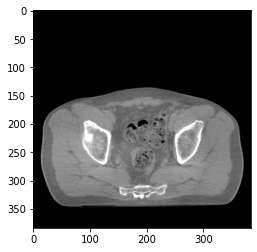

In [22]:
plt.imshow(x.squeeze(), 'gray'),

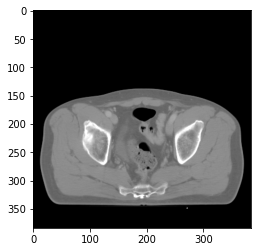

In [23]:
plt.imshow(y.squeeze(), 'gray')

In [24]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [25]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [26]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [27]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [28]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [29]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [30]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_mae, loss_ssim, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss ssim": loss_ssim,
            "loss mae": loss_mae,
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test >  max_score:
            max_score = score_bone_test +  score_air_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [03:01,  1.08s/it]
168it [00:47,  3.51it/s]
24it [00:07,  3.35it/s]
168it [03:02,  1.08s/it]
168it [00:48,  3.49it/s]
24it [00:07,  3.35it/s]
168it [03:02,  1.09s/it]
168it [00:48,  3.49it/s]
24it [00:07,  3.34it/s]
168it [03:02,  1.09s/it]
168it [00:48,  3.49it/s]
24it [00:07,  3.35it/s]
168it [03:02,  1.09s/it]
168it [00:48,  3.49it/s]
24it [00:07,  3.34it/s]
168it [03:03,  1.09s/it]
168it [00:48,  3.48it/s]
24it [00:07,  3.35it/s]
168it [03:02,  1.09s/it]
168it [00:48,  3.48it/s]
24it [00:07,  3.33it/s]
168it [03:02,  1.09s/it]
168it [00:48,  3.50it/s]
24it [00:07,  3.35it/s]
168it [03:02,  1.09s/it]
168it [00:48,  3.50it/s]
24it [00:07,  3.33it/s]
168it [03:02,  1.09s/it]
168it [00:48,  3.49it/s]
24it [00:07,  3.34it/s]
168it [03:02,  1.09s/it]
168it [00:48,  3.48it/s]
24it [00:07,  3.34it/s]
168it [03:02,  1.09s/it]
168it [00:48,  3.49it/s]
24it [00:07,  3.34it/s]
168it [03:02,  1.09s/it]
168it [00:48,  3.49it/s]
24it [00:07,  3.34it/s]
168it [03:02,  1.09s/it]
168it [00:48,

KeyboardInterrupt: 

In [31]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [32]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [33]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.9024840593338013
psnr score = 26.851001739501953
snr score = 16.913936614990234
mae error = 0.0151393236592412
air dice score = 0.9941326914397531
bone dice score = 0.9610091743124856


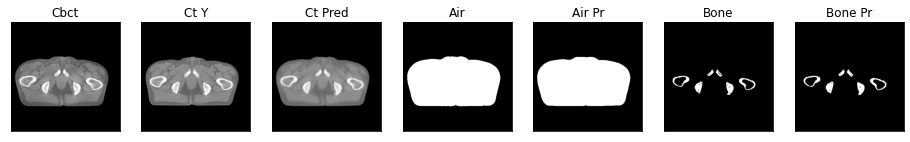

ssim score = 0.903670608997345
psnr score = 26.879587173461914
snr score = 16.990060806274414
mae error = 0.015225331299006939
air dice score = 0.9943397549564769
bone dice score = 0.9549343981752005


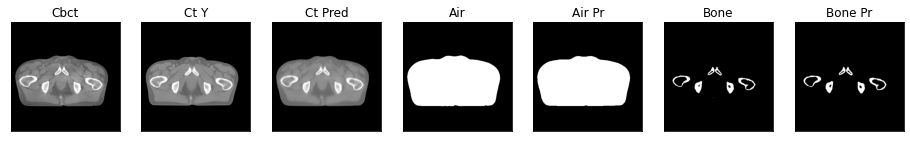

ssim score = 0.9025012850761414
psnr score = 26.716516494750977
snr score = 16.989885330200195
mae error = 0.016143254935741425
air dice score = 0.9947871764540822
bone dice score = 0.9499523355582703


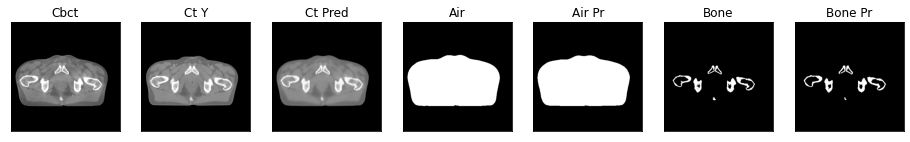

ssim score = 0.9004572033882141
psnr score = 26.77065658569336
snr score = 17.133277893066406
mae error = 0.016285158693790436
air dice score = 0.9947270627228497
bone dice score = 0.9392738566998043


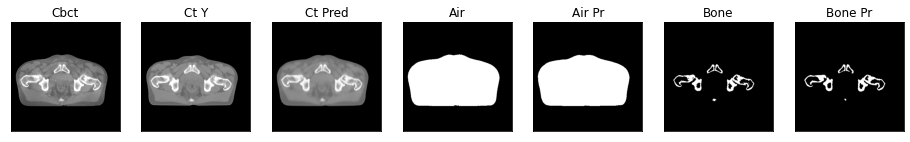

ssim score = 0.8998368382453918
psnr score = 26.90072250366211
snr score = 17.303647994995117
mae error = 0.01607583835721016
air dice score = 0.9946492810286333
bone dice score = 0.9344657851565055


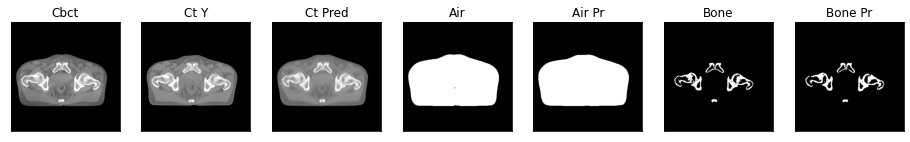

ssim score = 0.8951212167739868
psnr score = 26.830434799194336
snr score = 17.36989402770996
mae error = 0.016556033864617348
air dice score = 0.9948799935241076
bone dice score = 0.9296849087899695


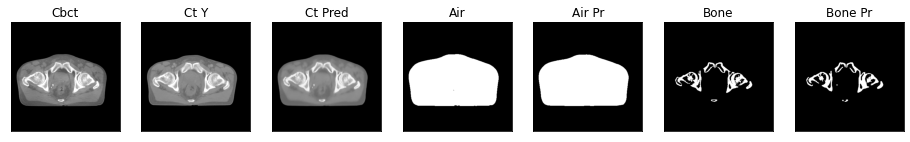

ssim score = 0.8935657143592834
psnr score = 26.903053283691406
snr score = 17.41845703125
mae error = 0.016665911301970482
air dice score = 0.9936031943284438
bone dice score = 0.9322900031944085


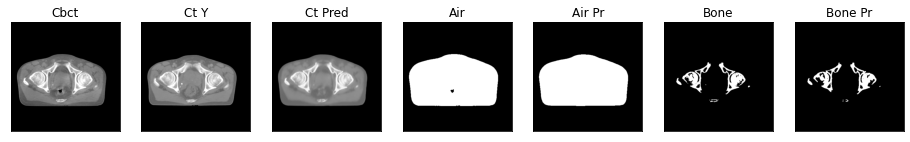

ssim score = 0.8949370980262756
psnr score = 27.246116638183594
snr score = 17.57598304748535
mae error = 0.015803661197423935
air dice score = 0.9940265781411756
bone dice score = 0.9425749497426573


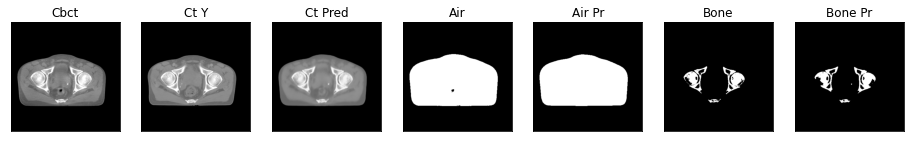

1it [00:02,  2.87s/it]

ssim score = 0.899495542049408
psnr score = 27.488327026367188
snr score = 17.7236385345459
mae error = 0.01525871828198433
air dice score = 0.9947220847765187
bone dice score = 0.9530444741367337


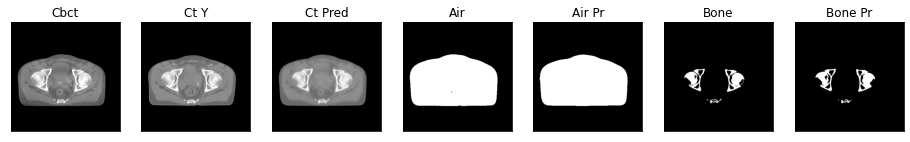

ssim score = 0.9033387303352356
psnr score = 27.73818016052246
snr score = 17.958208084106445
mae error = 0.014825373888015747
air dice score = 0.9944030819393016
bone dice score = 0.9467597208380184


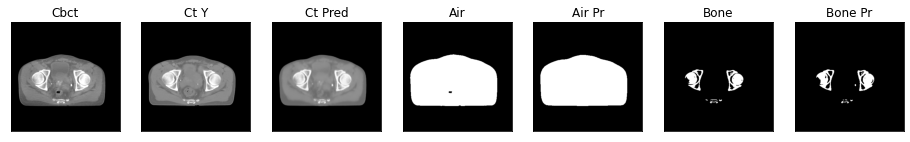

ssim score = 0.9087420105934143
psnr score = 27.93849754333496
snr score = 18.190792083740234
mae error = 0.014752945862710476
air dice score = 0.9944627857411567
bone dice score = 0.9552238805974855


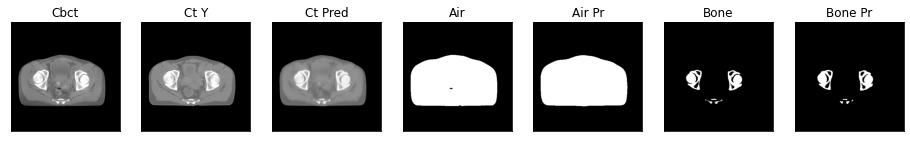

ssim score = 0.9100015759468079
psnr score = 27.679931640625
snr score = 17.95594024658203
mae error = 0.015197106637060642
air dice score = 0.9918503758526617
bone dice score = 0.9650275540486962


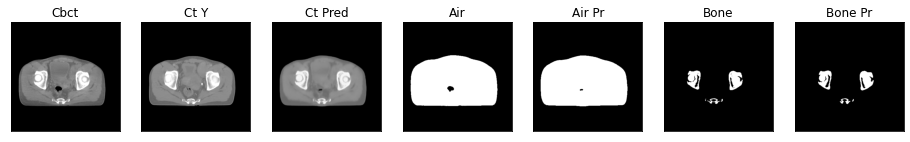

ssim score = 0.9148394465446472
psnr score = 26.56414222717285
snr score = 16.8082275390625
mae error = 0.016078723594546318
air dice score = 0.9927701064727381
bone dice score = 0.9712793733684723


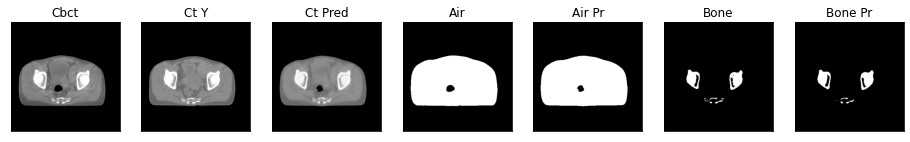

ssim score = 0.9113256335258484
psnr score = 26.59069061279297
snr score = 16.69281768798828
mae error = 0.015932496637105942
air dice score = 0.9912321280647303
bone dice score = 0.9482887834130865


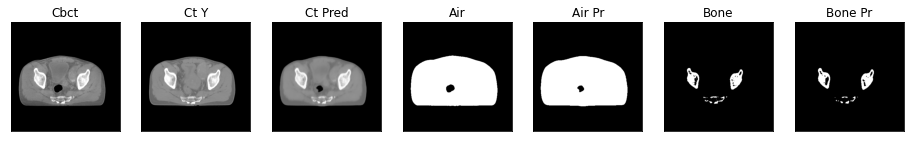

ssim score = 0.9112673401832581
psnr score = 27.67123031616211
snr score = 17.687698364257812
mae error = 0.01493470836430788
air dice score = 0.9877952713421017
bone dice score = 0.9307140960986101


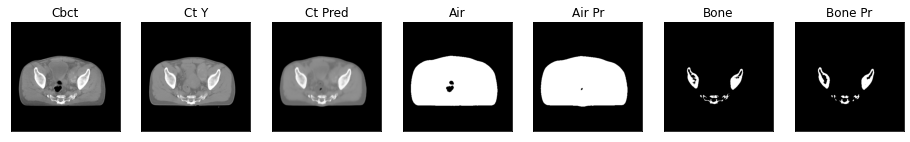

ssim score = 0.9048507809638977
psnr score = 26.996807098388672
snr score = 17.036760330200195
mae error = 0.01588173396885395
air dice score = 0.9890732936525296
bone dice score = 0.9398373983747362


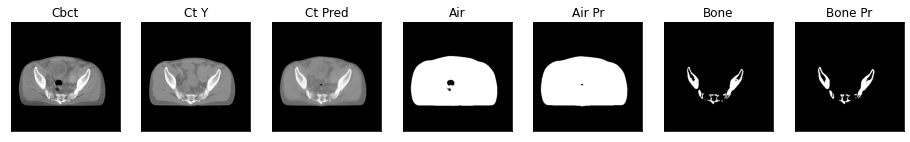

2it [00:05,  2.70s/it]

ssim score = 0.9008245468139648
psnr score = 26.247865676879883
snr score = 16.28527069091797
mae error = 0.01681477576494217
air dice score = 0.9871675247264047
bone dice score = 0.9410646387839702


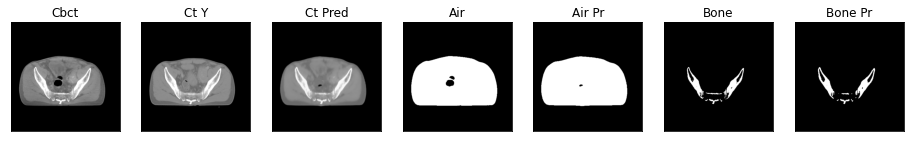

ssim score = 0.8943216800689697
psnr score = 25.770782470703125
snr score = 15.706429481506348
mae error = 0.01747497357428074
air dice score = 0.9842758926591436
bone dice score = 0.9240276263186231


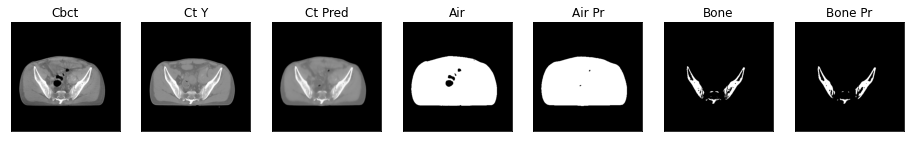

ssim score = 0.8937591314315796
psnr score = 25.363277435302734
snr score = 15.248245239257812
mae error = 0.01778995245695114
air dice score = 0.9846604831220732
bone dice score = 0.9238005644411593


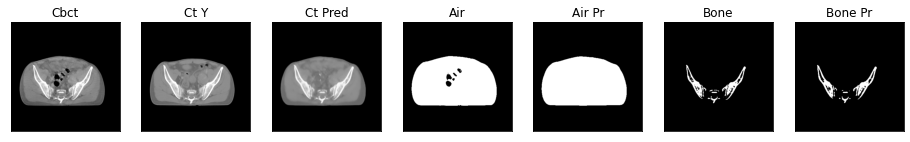

ssim score = 0.8906324505805969
psnr score = 24.659198760986328
snr score = 14.531854629516602
mae error = 0.018968069925904274
air dice score = 0.9862550698512998
bone dice score = 0.9267412486475791


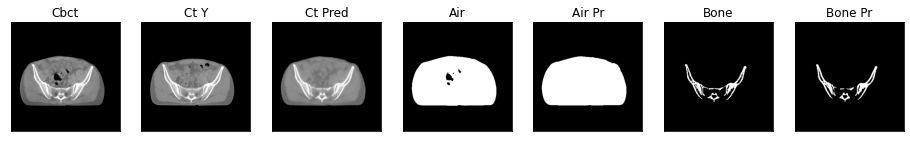

ssim score = 0.8847520351409912
psnr score = 24.03435516357422
snr score = 13.842162132263184
mae error = 0.020124318078160286
air dice score = 0.9879209245880208
bone dice score = 0.9143530644327612


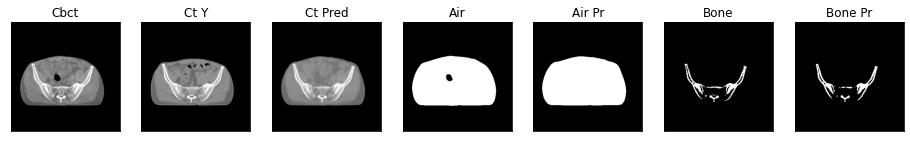

ssim score = 0.8819512128829956
psnr score = 23.657791137695312
snr score = 13.406170845031738
mae error = 0.020407123491168022
air dice score = 0.9878744813991475
bone dice score = 0.9289184351837264


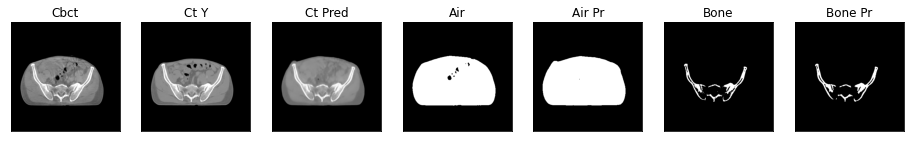

ssim score = 0.8832612633705139
psnr score = 23.543088912963867
snr score = 13.258039474487305
mae error = 0.020560085773468018
air dice score = 0.990412970822599
bone dice score = 0.9332856802485907


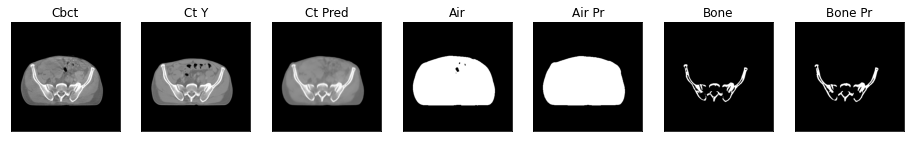

ssim score = 0.8832104206085205
psnr score = 23.3477783203125
snr score = 13.014163970947266
mae error = 0.02108624018728733
air dice score = 0.9912052955348265
bone dice score = 0.9258064516137579


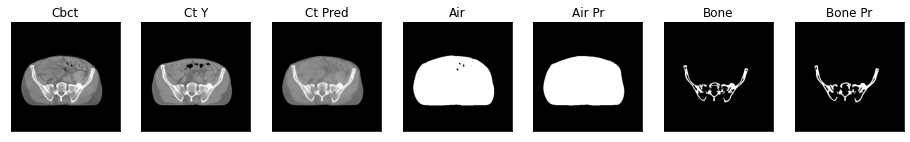

3it [00:07,  2.52s/it]

ssim score = 0.8839002847671509
psnr score = 23.263946533203125
snr score = 12.833333015441895
mae error = 0.021203914657235146
air dice score = 0.9917719868162191
bone dice score = 0.933940268680649


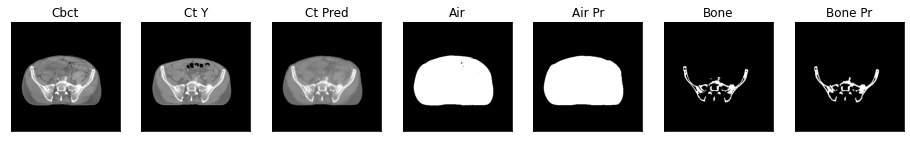

ssim score = 0.8862926363945007
psnr score = 23.429365158081055
snr score = 12.916019439697266
mae error = 0.02060130424797535
air dice score = 0.9898894727305794
bone dice score = 0.9187800245791669


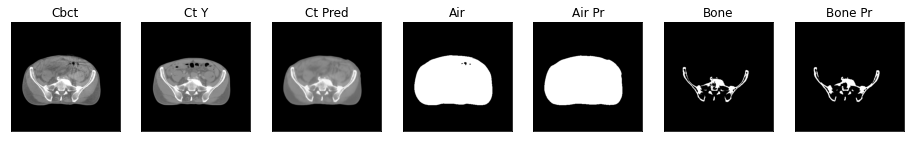

ssim score = 0.883182168006897
psnr score = 23.385501861572266
snr score = 12.780966758728027
mae error = 0.02105974592268467
air dice score = 0.9881719372448874
bone dice score = 0.9148070792578343


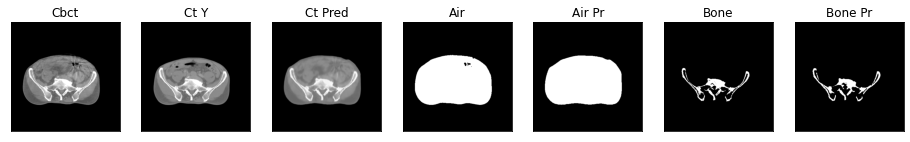

ssim score = 0.8832785487174988
psnr score = 23.32640838623047
snr score = 12.680769920349121
mae error = 0.021098226308822632
air dice score = 0.9868532654792361
bone dice score = 0.9274126455914371


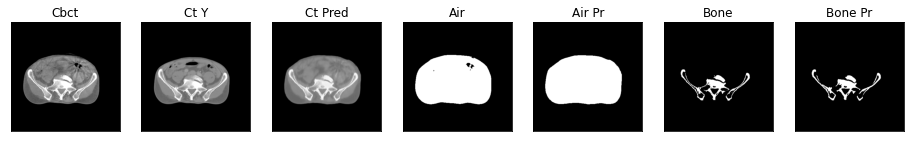

ssim score = 0.8746521472930908
psnr score = 23.738719940185547
snr score = 15.110878944396973
mae error = 0.021502509713172913
air dice score = 0.9931671975516875
bone dice score = 0.9810725552056444


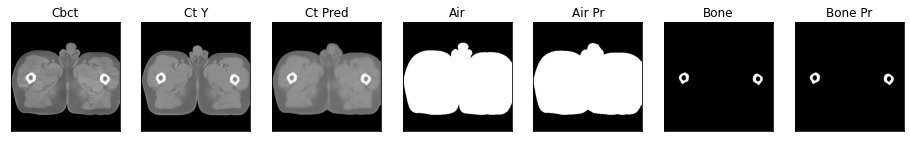

ssim score = 0.8782819509506226
psnr score = 24.37375259399414
snr score = 15.78516960144043
mae error = 0.020220749080181122
air dice score = 0.9939130219180837
bone dice score = 0.978748524203697


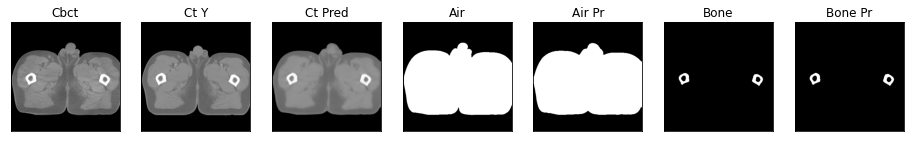

ssim score = 0.8887757062911987
psnr score = 25.344295501708984
snr score = 16.84316062927246
mae error = 0.018664078786969185
air dice score = 0.9949541934410707
bone dice score = 0.9685802031663459


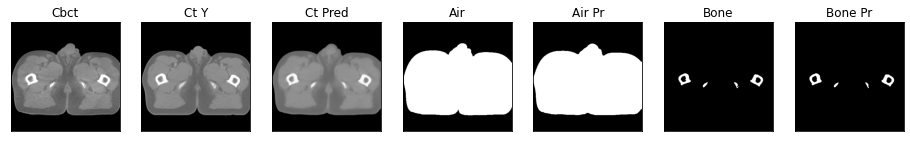

ssim score = 0.895288348197937
psnr score = 25.92867660522461
snr score = 17.590099334716797
mae error = 0.018268505111336708
air dice score = 0.9958000171427898
bone dice score = 0.9725063938623321


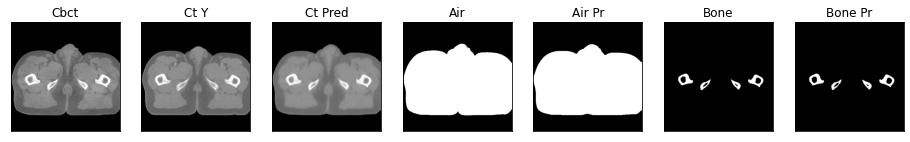

4it [00:09,  2.46s/it]

ssim score = 0.8969259858131409
psnr score = 26.312461853027344
snr score = 18.10202407836914
mae error = 0.018024222925305367
air dice score = 0.9962249882602646
bone dice score = 0.9607225947726739


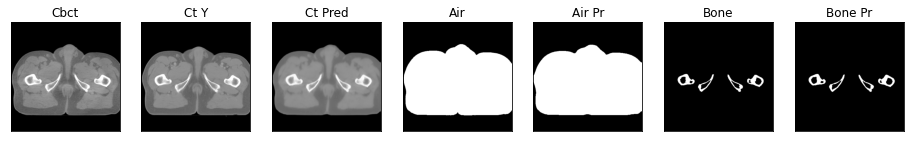

ssim score = 0.8991881608963013
psnr score = 26.930885314941406
snr score = 18.823688507080078
mae error = 0.01738145388662815
air dice score = 0.9962879933900789
bone dice score = 0.95463745684064


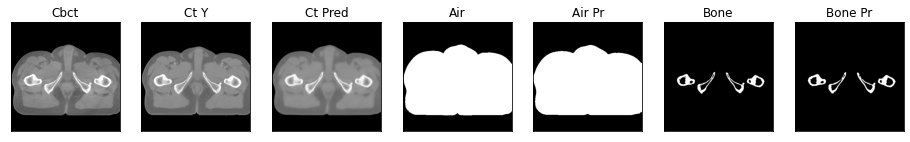

ssim score = 0.9013808369636536
psnr score = 27.415964126586914
snr score = 19.37586784362793
mae error = 0.017309848219156265
air dice score = 0.9962221657161562
bone dice score = 0.9488382240651376


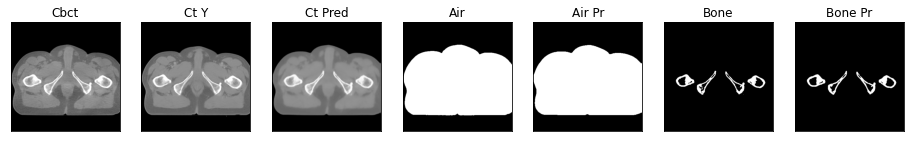

ssim score = 0.9003288745880127
psnr score = 27.512554168701172
snr score = 19.462568283081055
mae error = 0.017039338126778603
air dice score = 0.9961493892134637
bone dice score = 0.9590909090913317


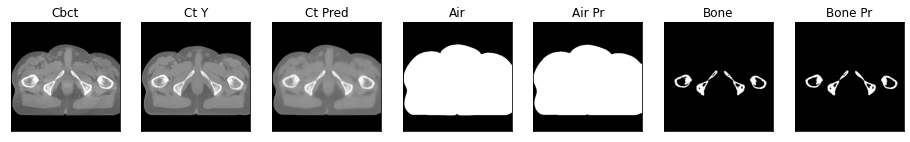

ssim score = 0.9019745588302612
psnr score = 27.555845260620117
snr score = 19.49219512939453
mae error = 0.01696874015033245
air dice score = 0.9961089962896954
bone dice score = 0.9632961864843749


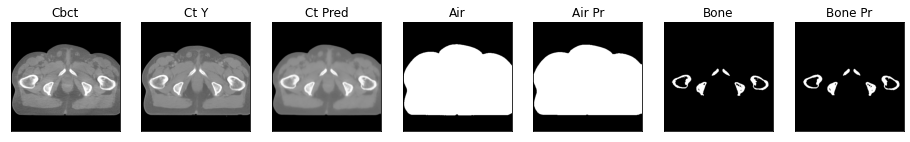

ssim score = 0.9047670364379883
psnr score = 27.697418212890625
snr score = 19.645767211914062
mae error = 0.017087241634726524
air dice score = 0.9959459134326228
bone dice score = 0.9551296013945205


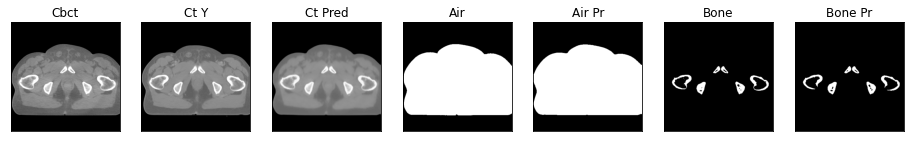

ssim score = 0.9051751494407654
psnr score = 27.603187561035156
snr score = 19.590621948242188
mae error = 0.017074033617973328
air dice score = 0.9956841624389918
bone dice score = 0.9568522244583406


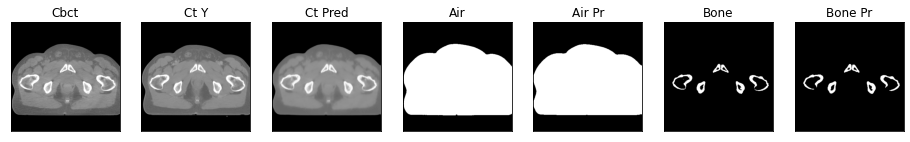

ssim score = 0.9038264155387878
psnr score = 27.579261779785156
snr score = 19.70798683166504
mae error = 0.017601249739527702
air dice score = 0.9957437087446371
bone dice score = 0.9575642245484532


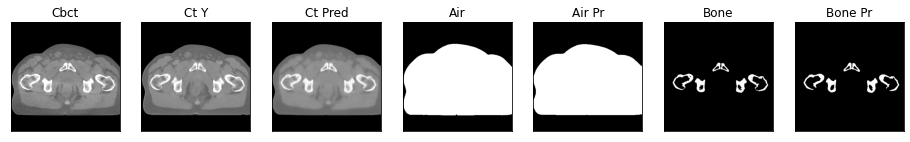

5it [00:11,  2.35s/it]

ssim score = 0.9033093452453613
psnr score = 27.724933624267578
snr score = 19.94834327697754
mae error = 0.01761864311993122
air dice score = 0.9957492413660254
bone dice score = 0.9510246063774743


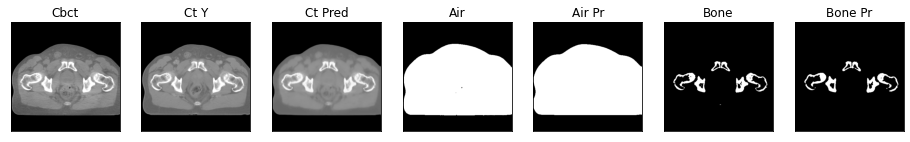

ssim score = 0.8941792249679565
psnr score = 27.10526466369629
snr score = 19.294626235961914
mae error = 0.019100012257695198
air dice score = 0.9948034369826128
bone dice score = 0.9353195430693476


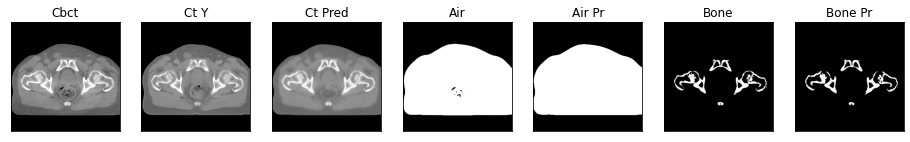

ssim score = 0.8916482329368591
psnr score = 27.174394607543945
snr score = 19.435943603515625
mae error = 0.01901359297335148
air dice score = 0.9929599280807191
bone dice score = 0.9208207198121707


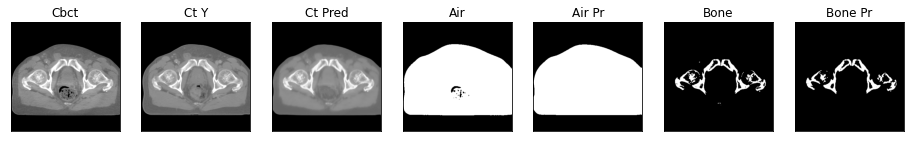

ssim score = 0.8881346583366394
psnr score = 26.831083297729492
snr score = 18.956539154052734
mae error = 0.01940111443400383
air dice score = 0.9934208923219416
bone dice score = 0.9045199719700024


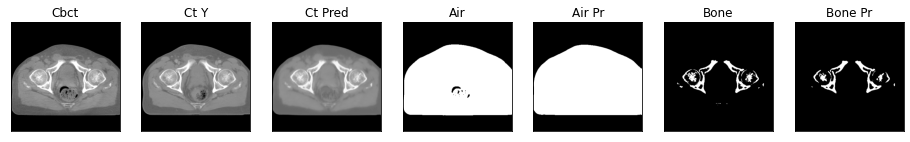

ssim score = 0.8887836933135986
psnr score = 26.422269821166992
snr score = 18.369163513183594
mae error = 0.019110092893242836
air dice score = 0.9938956206119082
bone dice score = 0.9000492368301325


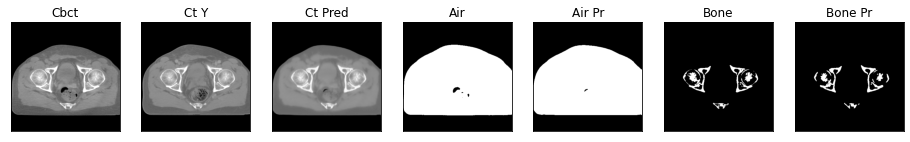

ssim score = 0.887614369392395
psnr score = 26.029512405395508
snr score = 17.885820388793945
mae error = 0.01984415203332901
air dice score = 0.9952889427995594
bone dice score = 0.876040494939527


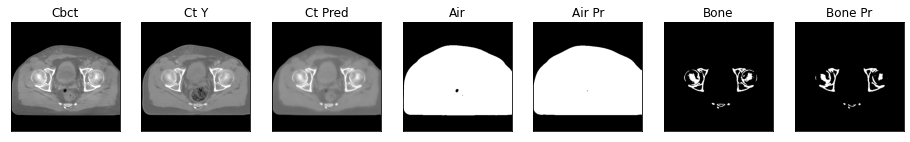

ssim score = 0.887846052646637
psnr score = 25.815074920654297
snr score = 17.687068939208984
mae error = 0.019986022263765335
air dice score = 0.9960253002559584
bone dice score = 0.9021489672449181


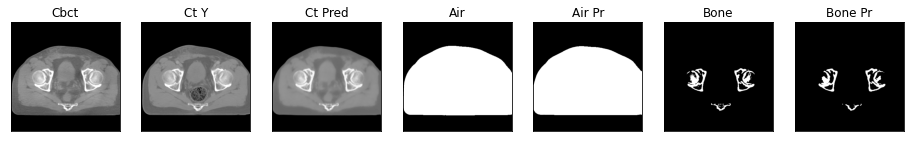

ssim score = 0.8776388764381409
psnr score = 25.727432250976562
snr score = 17.60946273803711
mae error = 0.020938778296113014
air dice score = 0.9959913889095118
bone dice score = 0.9093103128199266


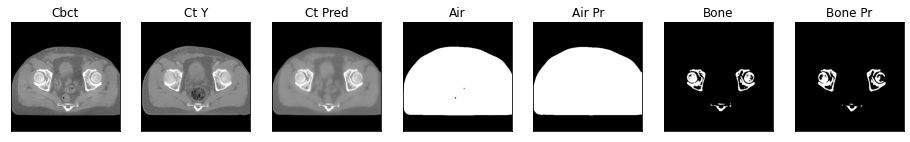

6it [00:14,  2.34s/it]

ssim score = 0.8850102424621582
psnr score = 26.16446304321289
snr score = 18.108081817626953
mae error = 0.020030809566378593
air dice score = 0.9959453334078473
bone dice score = 0.9410699737490624


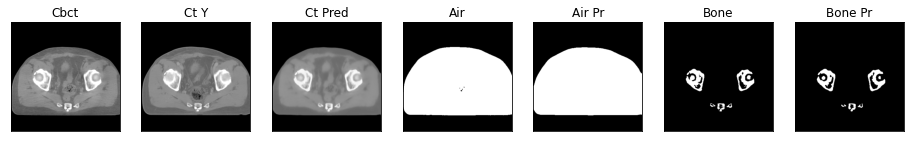

ssim score = 0.888013482093811
psnr score = 26.8995361328125
snr score = 18.913236618041992
mae error = 0.01951797679066658
air dice score = 0.9958100645611178
bone dice score = 0.9603701117321896


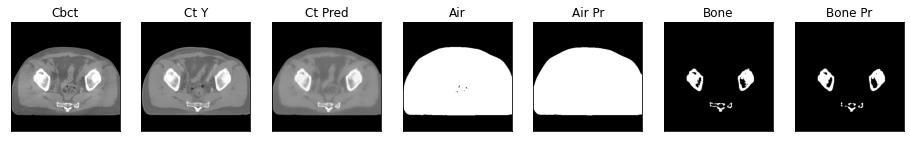

ssim score = 0.8904412984848022
psnr score = 26.50188446044922
snr score = 18.396480560302734
mae error = 0.019635429605841637
air dice score = 0.9958858494382747
bone dice score = 0.9458795796096073


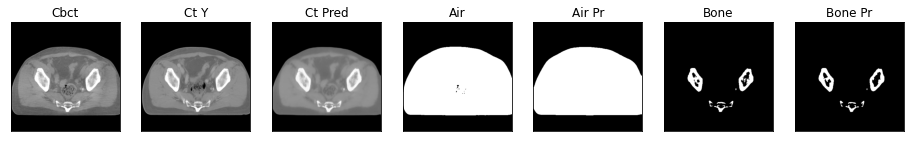

ssim score = 0.8855466842651367
psnr score = 25.963191986083984
snr score = 17.939414978027344
mae error = 0.021238898858428
air dice score = 0.9951128520798389
bone dice score = 0.9592866756396426


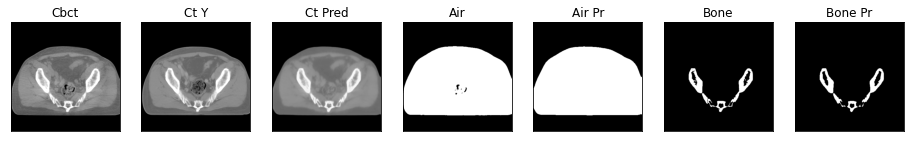

ssim score = 0.885299026966095
psnr score = 26.21221160888672
snr score = 18.26858139038086
mae error = 0.020961297675967216
air dice score = 0.9938644978379992
bone dice score = 0.9576277141454738


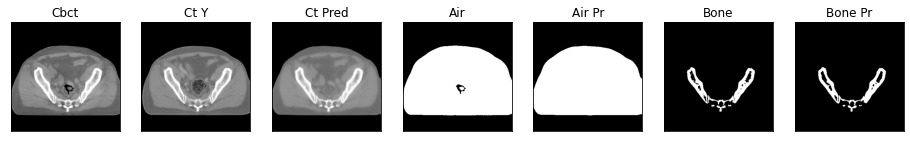

ssim score = 0.871561586856842
psnr score = 25.795940399169922
snr score = 17.873870849609375
mae error = 0.02266165241599083
air dice score = 0.9936619239307241
bone dice score = 0.9493074597486514


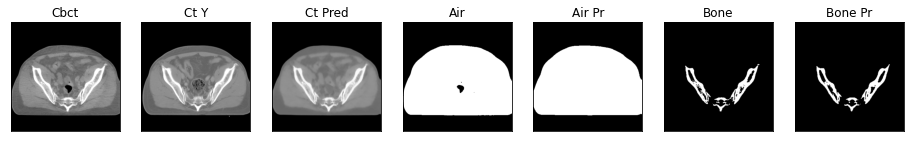

ssim score = 0.8718737959861755
psnr score = 25.918302536010742
snr score = 18.008769989013672
mae error = 0.022570917382836342
air dice score = 0.9958216072065011
bone dice score = 0.9577784074811718


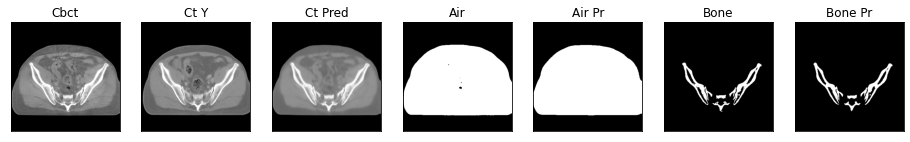

ssim score = 0.8244345784187317
psnr score = 21.36536407470703
snr score = 11.245573043823242
mae error = 0.03110502101480961
air dice score = 0.9777098953994467
bone dice score = 0.9651741293541964


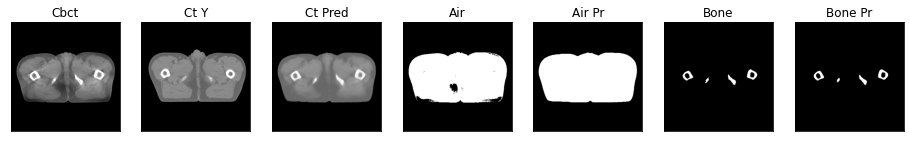

7it [00:16,  2.27s/it]

ssim score = 0.8127327561378479
psnr score = 20.94841766357422
snr score = 11.041604995727539
mae error = 0.033957820385694504
air dice score = 0.9782534609326988
bone dice score = 0.942646730641762


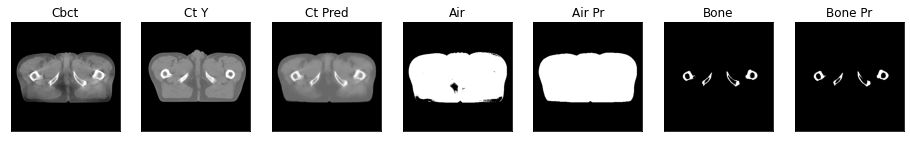

ssim score = 0.8074062466621399
psnr score = 20.924911499023438
snr score = 11.149236679077148
mae error = 0.03456629440188408
air dice score = 0.9783411024516422
bone dice score = 0.9125671321178825


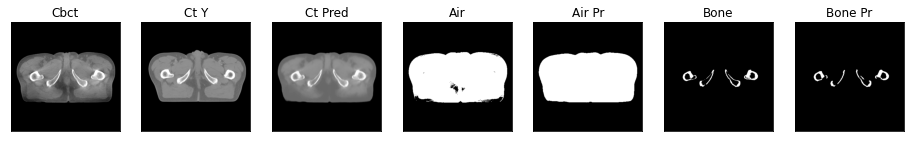

ssim score = 0.8105242252349854
psnr score = 21.23491096496582
snr score = 11.529640197753906
mae error = 0.0336114875972271
air dice score = 0.9762966353856934
bone dice score = 0.9034813425077448


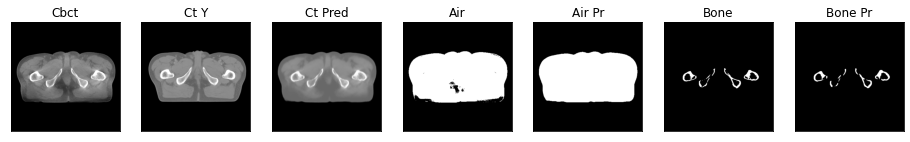

ssim score = 0.8116222023963928
psnr score = 21.2943115234375
snr score = 11.636609077453613
mae error = 0.033421408385038376
air dice score = 0.97815398929137
bone dice score = 0.9057824504669272


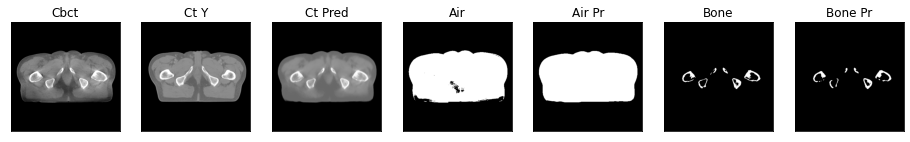

ssim score = 0.8124233484268188
psnr score = 21.441926956176758
snr score = 11.789837837219238
mae error = 0.03282638266682625
air dice score = 0.9785751959696828
bone dice score = 0.9053529868133174


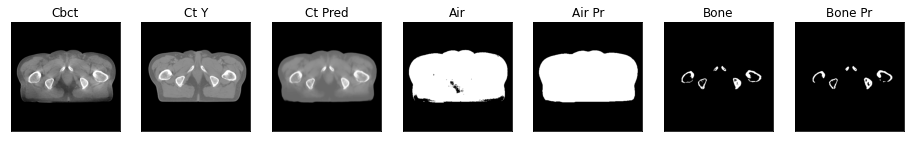

ssim score = 0.8129067420959473
psnr score = 21.495874404907227
snr score = 11.83728313446045
mae error = 0.03242679312825203
air dice score = 0.9796321464166172
bone dice score = 0.9321545262361685


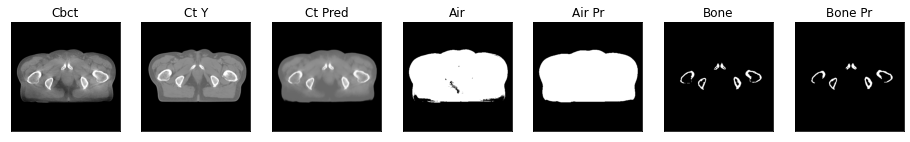

ssim score = 0.8119221925735474
psnr score = 21.340465545654297
snr score = 11.695984840393066
mae error = 0.0329446978867054
air dice score = 0.9813468795878648
bone dice score = 0.9368537666185958


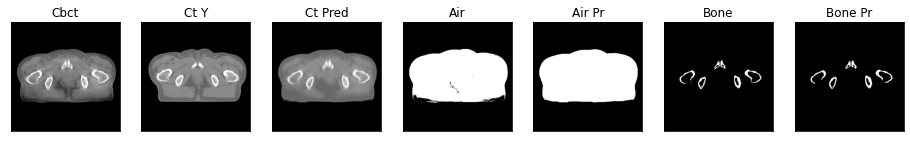

ssim score = 0.8109638690948486
psnr score = 21.248645782470703
snr score = 11.662174224853516
mae error = 0.03391294553875923
air dice score = 0.981900411884545
bone dice score = 0.9162790697688326


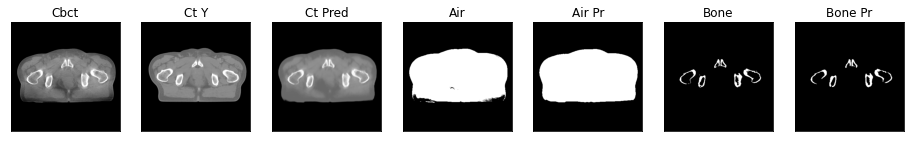

8it [00:18,  2.28s/it]

ssim score = 0.8031576871871948
psnr score = 21.055776596069336
snr score = 11.567863464355469
mae error = 0.035753458738327026
air dice score = 0.9821455767077427
bone dice score = 0.8850760764019897


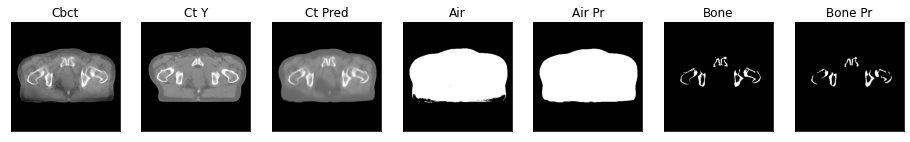

ssim score = 0.7926309108734131
psnr score = 20.887264251708984
snr score = 11.435182571411133
mae error = 0.03692606836557388
air dice score = 0.9814564678731011
bone dice score = 0.8859204667605417


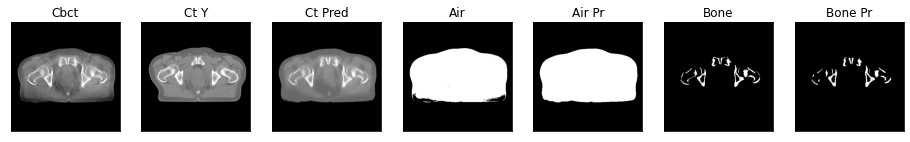

ssim score = 0.7815159559249878
psnr score = 20.76866340637207
snr score = 11.349285125732422
mae error = 0.037209440022706985
air dice score = 0.9809508506953913
bone dice score = 0.8591568762977311


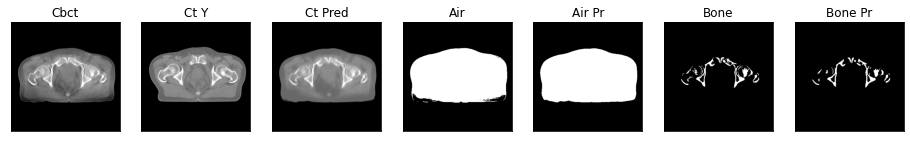

ssim score = 0.7836145758628845
psnr score = 20.753992080688477
snr score = 11.451430320739746
mae error = 0.03778587654232979
air dice score = 0.980404748526137
bone dice score = 0.8503044894512065


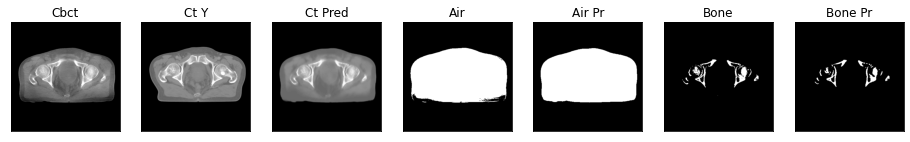

ssim score = 0.7861699461936951
psnr score = 20.66521644592285
snr score = 11.34666633605957
mae error = 0.03824561461806297
air dice score = 0.9799183178470333
bone dice score = 0.8369668246471254


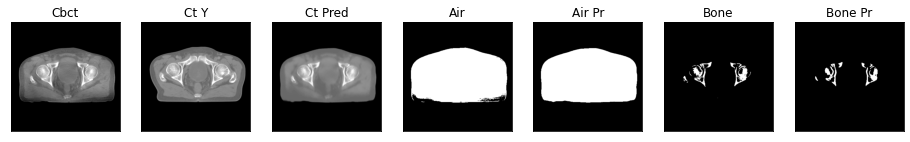

ssim score = 0.8011962175369263
psnr score = 21.2418212890625
snr score = 11.724108695983887
mae error = 0.0346360057592392
air dice score = 0.9790063916845886
bone dice score = 0.8789133675686779


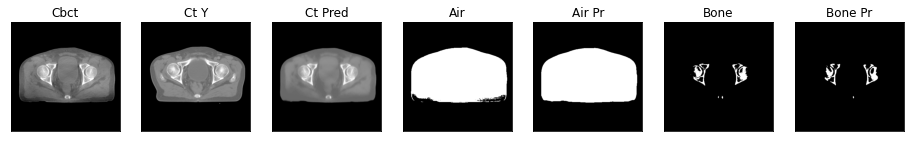

ssim score = 0.8175986409187317
psnr score = 21.969327926635742
snr score = 12.281225204467773
mae error = 0.031231628730893135
air dice score = 0.9786783419652423
bone dice score = 0.9204747774492511


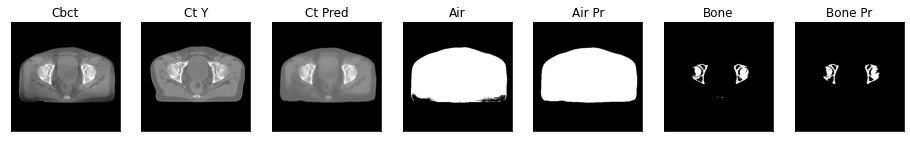

ssim score = 0.825715959072113
psnr score = 22.36467170715332
snr score = 12.690735816955566
mae error = 0.02968631498515606
air dice score = 0.9776322579497325
bone dice score = 0.9391233766242002


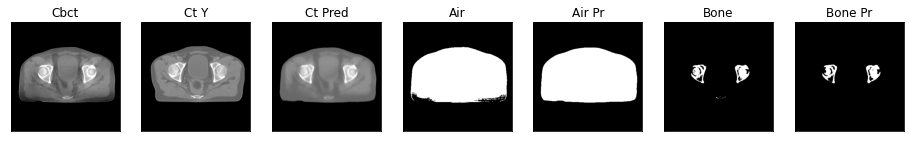

9it [00:20,  2.28s/it]

ssim score = 0.8296837210655212
psnr score = 22.555255889892578
snr score = 12.96314811706543
mae error = 0.02925679460167885
air dice score = 0.976941067665048
bone dice score = 0.9477133105809186


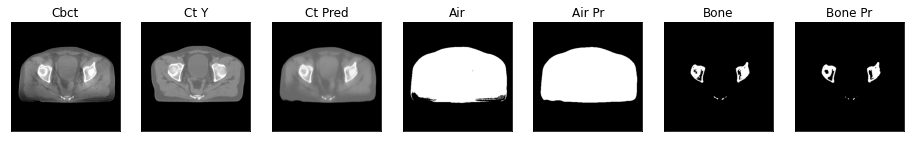

ssim score = 0.8297473192214966
psnr score = 22.449546813964844
snr score = 12.94961166381836
mae error = 0.029835164546966553
air dice score = 0.975744877303903
bone dice score = 0.9397108581984049


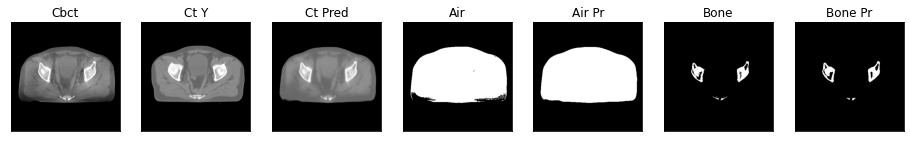

ssim score = 0.8274895548820496
psnr score = 22.758939743041992
snr score = 13.195577621459961
mae error = 0.028629520907998085
air dice score = 0.9771047572010856
bone dice score = 0.9471729957814823


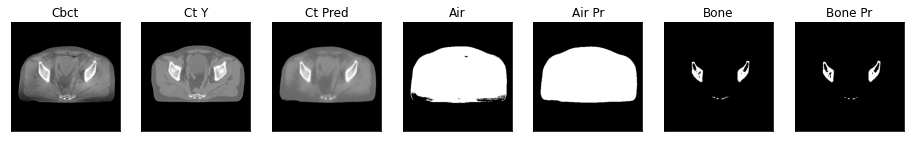

ssim score = 0.8319236040115356
psnr score = 23.130611419677734
snr score = 13.530856132507324
mae error = 0.02718992903828621
air dice score = 0.9763602119308089
bone dice score = 0.9499634769914178


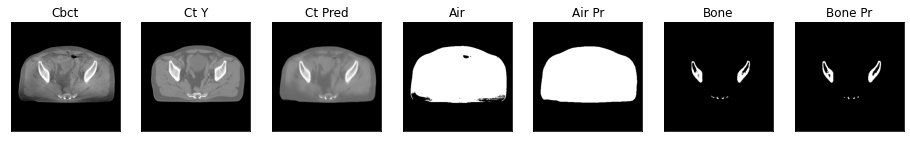

ssim score = 0.8293044567108154
psnr score = 23.061870574951172
snr score = 13.499860763549805
mae error = 0.02817021869122982
air dice score = 0.9768054823405581
bone dice score = 0.9243095806354533


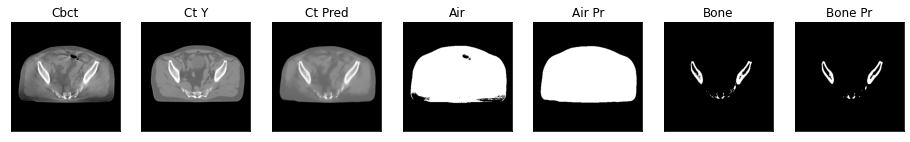

ssim score = 0.824110209941864
psnr score = 22.86697006225586
snr score = 13.435464859008789
mae error = 0.029223347082734108
air dice score = 0.9781568107362937
bone dice score = 0.9281848764088316


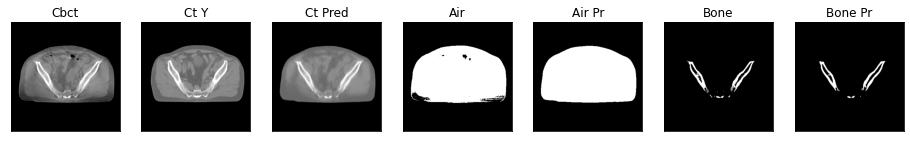

ssim score = 0.8278020024299622
psnr score = 22.86241912841797
snr score = 13.448662757873535
mae error = 0.029120972380042076
air dice score = 0.9788448830345136
bone dice score = 0.9021464646480091


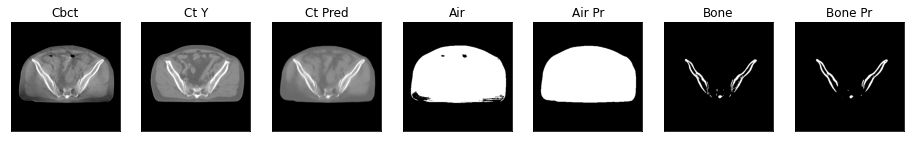

ssim score = 0.8302966952323914
psnr score = 23.182422637939453
snr score = 13.757400512695312
mae error = 0.02829836495220661
air dice score = 0.9800732004880208
bone dice score = 0.9221979499256898


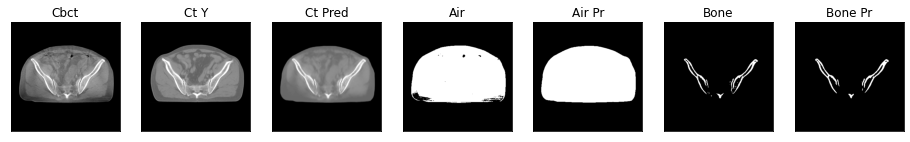

10it [00:22,  2.22s/it]

ssim score = 0.8334754109382629
psnr score = 23.34137725830078
snr score = 13.915611267089844
mae error = 0.027569202706217766
air dice score = 0.9804947247096547
bone dice score = 0.9075767472255458


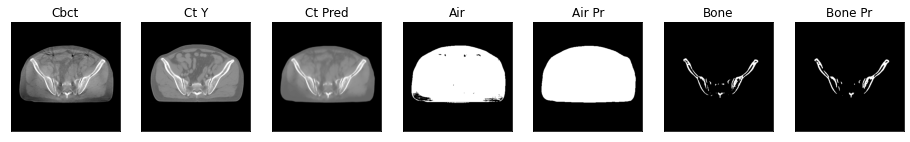

ssim score = 0.8798584938049316
psnr score = 24.730792999267578
snr score = 15.164926528930664
mae error = 0.019058166071772575
air dice score = 0.9946863492473716
bone dice score = 0.9635596471053487


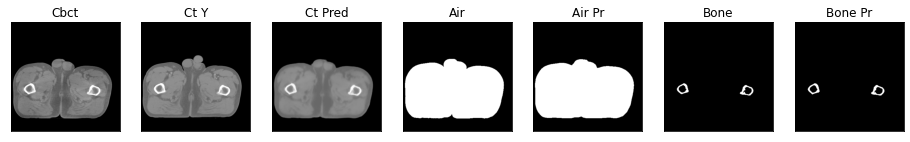

ssim score = 0.87891685962677
psnr score = 24.892873764038086
snr score = 15.391401290893555
mae error = 0.018993157893419266
air dice score = 0.9947308390496276
bone dice score = 0.9474804826136451


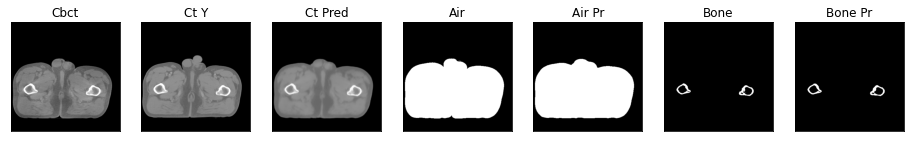

ssim score = 0.8883324265480042
psnr score = 26.784637451171875
snr score = 17.422374725341797
mae error = 0.017594024538993835
air dice score = 0.9943938888624244
bone dice score = 0.9525990382424411


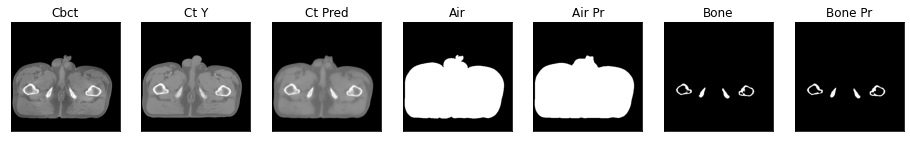

ssim score = 0.8882880210876465
psnr score = 26.669757843017578
snr score = 17.428985595703125
mae error = 0.018236877396702766
air dice score = 0.9946052683543346
bone dice score = 0.9349112426049767


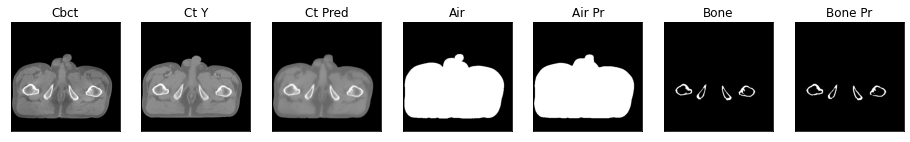

ssim score = 0.8848931789398193
psnr score = 26.450023651123047
snr score = 17.233428955078125
mae error = 0.018499577417969704
air dice score = 0.9947377542499766
bone dice score = 0.9141542002321253


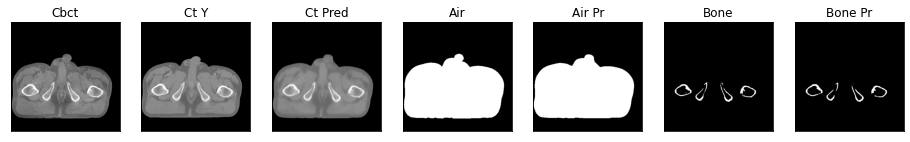

ssim score = 0.8849095106124878
psnr score = 26.237289428710938
snr score = 17.016298294067383
mae error = 0.018700335174798965
air dice score = 0.9942890406217596
bone dice score = 0.9064143007380354


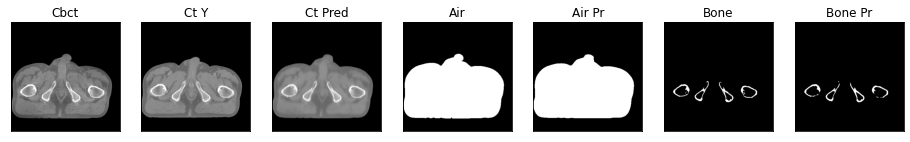

ssim score = 0.8854377865791321
psnr score = 25.807601928710938
snr score = 16.592864990234375
mae error = 0.019287021830677986
air dice score = 0.9945189320961
bone dice score = 0.897592819259535


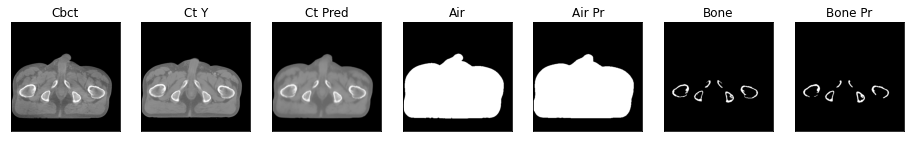

11it [00:25,  2.24s/it]

ssim score = 0.8832117319107056
psnr score = 25.531919479370117
snr score = 16.295625686645508
mae error = 0.01922653801739216
air dice score = 0.9948411792040492
bone dice score = 0.9153217772481506


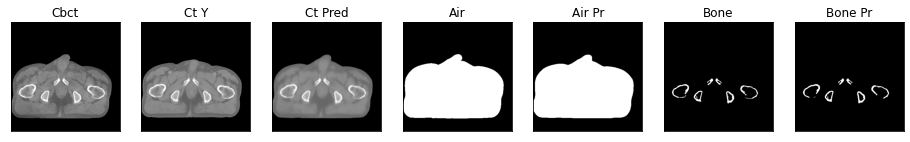

ssim score = 0.8846241235733032
psnr score = 25.558387756347656
snr score = 16.339004516601562
mae error = 0.019060194492340088
air dice score = 0.9947700232267892
bone dice score = 0.9211941405540294


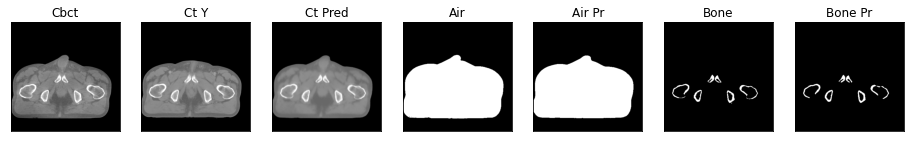

ssim score = 0.8855084776878357
psnr score = 25.911945343017578
snr score = 16.761154174804688
mae error = 0.018760254606604576
air dice score = 0.9951158402182053
bone dice score = 0.9194425560856655


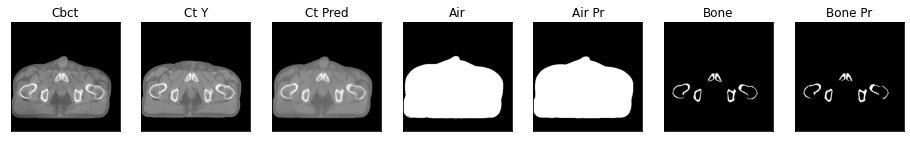

ssim score = 0.88747239112854
psnr score = 26.42673110961914
snr score = 17.3572998046875
mae error = 0.018323637545108795
air dice score = 0.9948717131981757
bone dice score = 0.9138635649180468


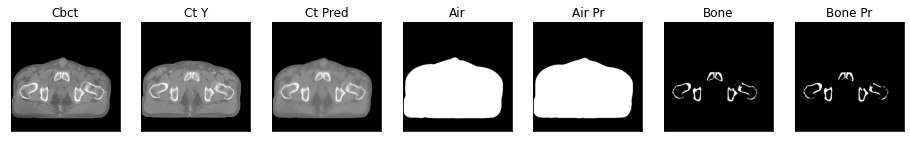

ssim score = 0.8895618319511414
psnr score = 26.944684982299805
snr score = 17.925954818725586
mae error = 0.017979782074689865
air dice score = 0.9944776990146214
bone dice score = 0.87650740345174


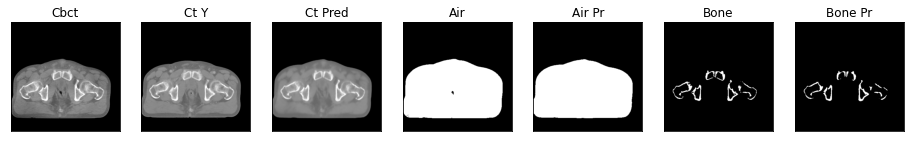

ssim score = 0.8920305967330933
psnr score = 27.270977020263672
snr score = 18.368515014648438
mae error = 0.017866726964712143
air dice score = 0.994122599526926
bone dice score = 0.8679937879448257


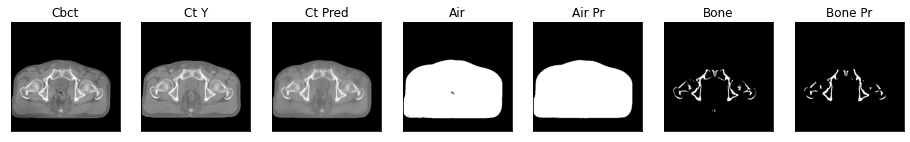

ssim score = 0.8896790742874146
psnr score = 27.06798553466797
snr score = 18.127286911010742
mae error = 0.017909221351146698
air dice score = 0.9935996646675747
bone dice score = 0.8483455882376173


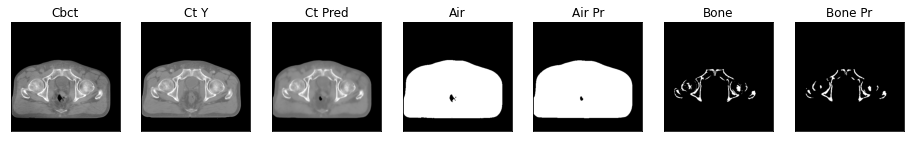

ssim score = 0.8844044208526611
psnr score = 26.988746643066406
snr score = 17.952381134033203
mae error = 0.017749996855854988
air dice score = 0.9899870172022152
bone dice score = 0.826540826543307


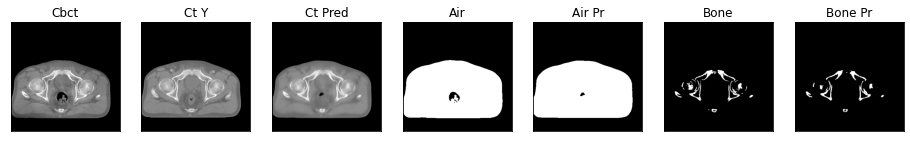

12it [00:27,  2.20s/it]

ssim score = 0.8889874219894409
psnr score = 27.432748794555664
snr score = 18.236621856689453
mae error = 0.016868704929947853
air dice score = 0.9871880552250345
bone dice score = 0.8383729301684958


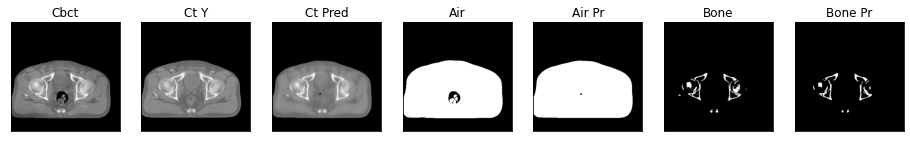

ssim score = 0.8836480379104614
psnr score = 25.21772003173828
snr score = 15.905169486999512
mae error = 0.019085824489593506
air dice score = 0.9928211242765292
bone dice score = 0.8513982818524695


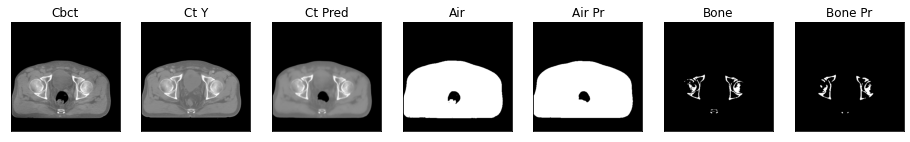

ssim score = 0.8826645016670227
psnr score = 25.242795944213867
snr score = 15.885149002075195
mae error = 0.018915385007858276
air dice score = 0.9925721137832318
bone dice score = 0.8759148936191333


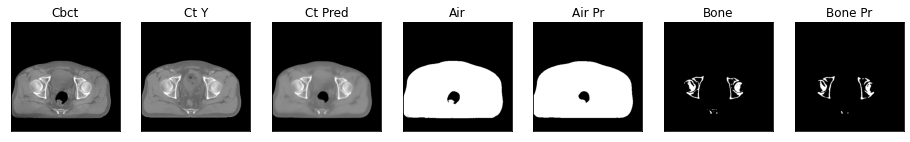

ssim score = 0.8763902187347412
psnr score = 24.253368377685547
snr score = 14.902395248413086
mae error = 0.020937010645866394
air dice score = 0.993298572813268
bone dice score = 0.917074763305304


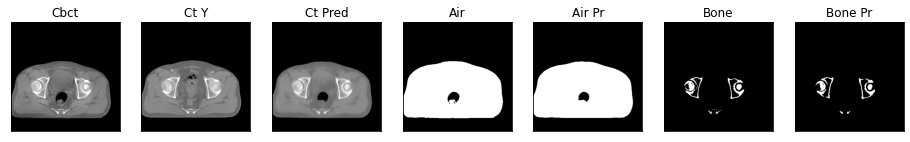

ssim score = 0.8777450323104858
psnr score = 23.74641227722168
snr score = 14.425545692443848
mae error = 0.022233178839087486
air dice score = 0.9937085843058133
bone dice score = 0.9381038647352339


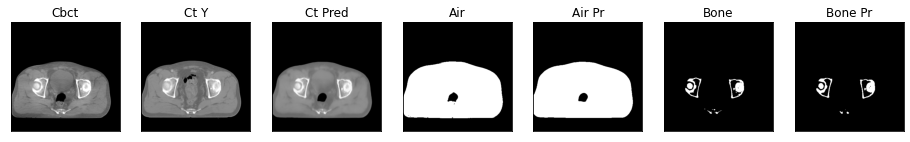

ssim score = 0.884538471698761
psnr score = 24.741737365722656
snr score = 15.37828254699707
mae error = 0.020375991240143776
air dice score = 0.9926727991244182
bone dice score = 0.9280600068201831


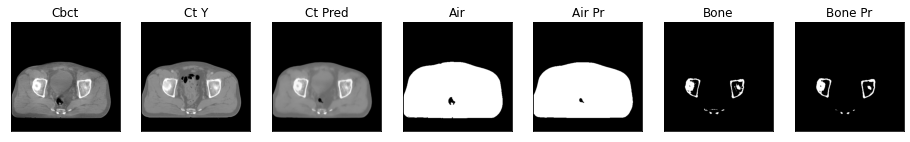

ssim score = 0.88607257604599
psnr score = 24.85561180114746
snr score = 15.40195369720459
mae error = 0.019365163519978523
air dice score = 0.9930621387404527
bone dice score = 0.9176334106744464


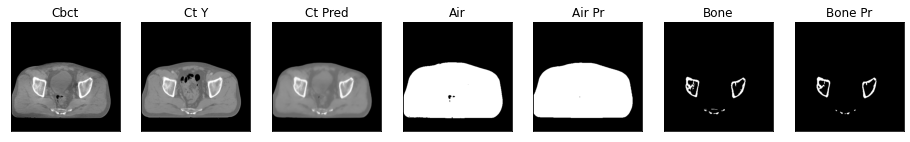

ssim score = 0.8868057727813721
psnr score = 24.882312774658203
snr score = 15.362926483154297
mae error = 0.019268108531832695
air dice score = 0.9923271493710357
bone dice score = 0.9343182271923673


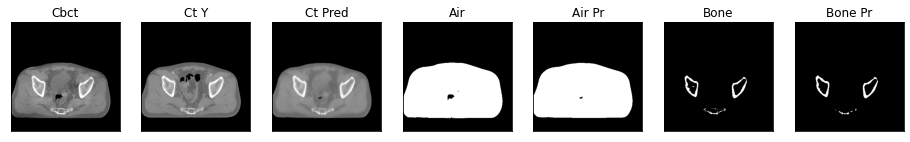

13it [00:29,  2.22s/it]

ssim score = 0.886737585067749
psnr score = 25.178585052490234
snr score = 15.65889835357666
mae error = 0.018985062837600708
air dice score = 0.991261158237902
bone dice score = 0.9310829817171047


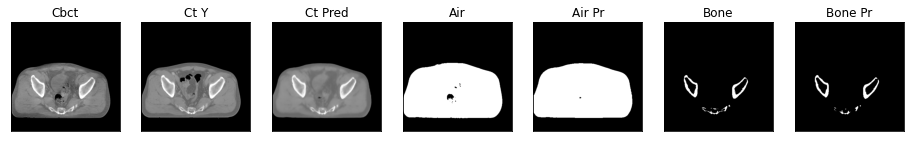

ssim score = 0.882393479347229
psnr score = 25.34735870361328
snr score = 15.903837203979492
mae error = 0.019617626443505287
air dice score = 0.989962812478488
bone dice score = 0.9230546297649174


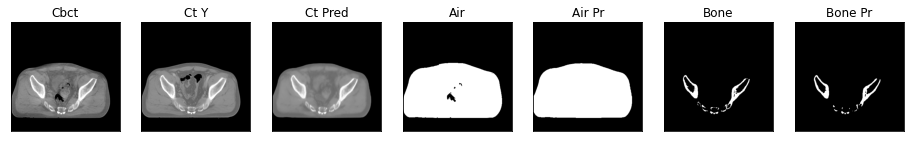

ssim score = 0.8853091597557068
psnr score = 25.395898818969727
snr score = 15.98796272277832
mae error = 0.019149813801050186
air dice score = 0.9892495527883524
bone dice score = 0.9236905078446731


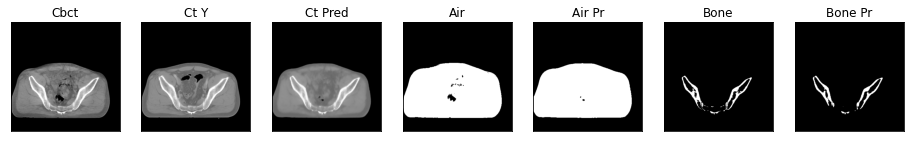

ssim score = 0.8880000114440918
psnr score = 25.63409423828125
snr score = 16.164457321166992
mae error = 0.018517443910241127
air dice score = 0.9899882934670645
bone dice score = 0.9033891154562876


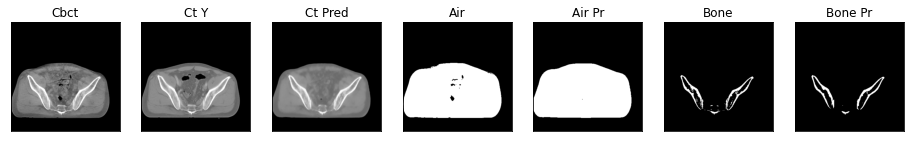

ssim score = 0.8865041732788086
psnr score = 25.298463821411133
snr score = 15.767568588256836
mae error = 0.019049199298024178
air dice score = 0.9898050974512833
bone dice score = 0.8968845985096258


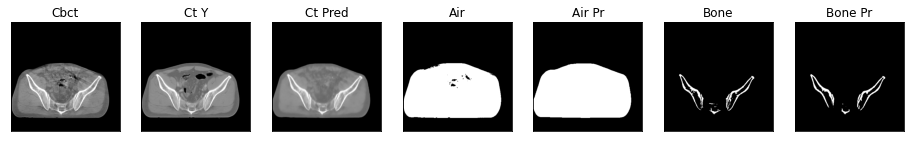

ssim score = 0.826956033706665
psnr score = 22.89240837097168
snr score = 14.589714050292969
mae error = 0.028135988861322403
air dice score = 0.9949109110068045
bone dice score = 0.9695256047763265


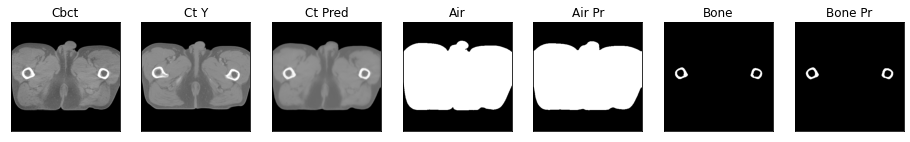

ssim score = 0.8163270354270935
psnr score = 22.527429580688477
snr score = 14.329028129577637
mae error = 0.029668761417269707
air dice score = 0.9955164960791696
bone dice score = 0.9680339462526723


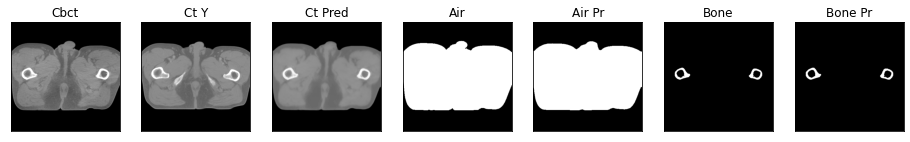

ssim score = 0.8090929388999939
psnr score = 22.15646743774414
snr score = 14.08602237701416
mae error = 0.031824417412281036
air dice score = 0.9957086130451066
bone dice score = 0.942713107242376


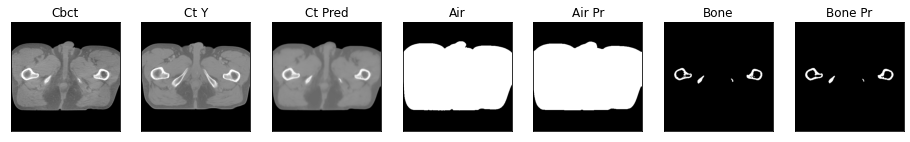

14it [00:31,  2.18s/it]

ssim score = 0.8001239895820618
psnr score = 21.8411922454834
snr score = 13.803035736083984
mae error = 0.03251078724861145
air dice score = 0.9956967734679769
bone dice score = 0.9525711432858617


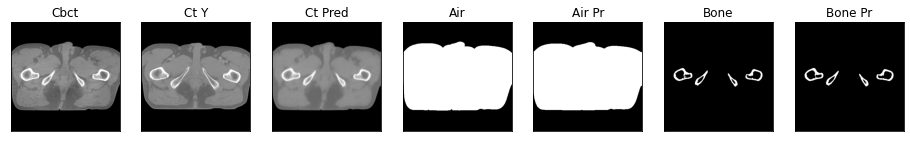

ssim score = 0.7921775579452515
psnr score = 21.689373016357422
snr score = 13.6814546585083
mae error = 0.03344029560685158
air dice score = 0.9955310494654406
bone dice score = 0.9313597918033286


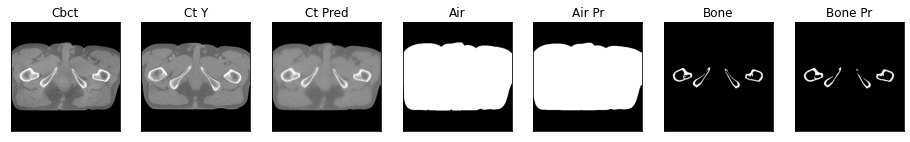

ssim score = 0.7857756018638611
psnr score = 21.603029251098633
snr score = 13.629526138305664
mae error = 0.03433383256196976
air dice score = 0.9954927919976491
bone dice score = 0.9353494831054567


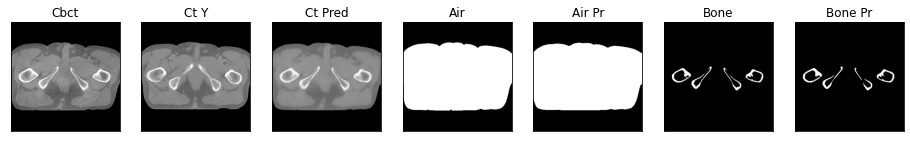

ssim score = 0.7798750400543213
psnr score = 21.330318450927734
snr score = 13.377124786376953
mae error = 0.03554360195994377
air dice score = 0.9958655633683074
bone dice score = 0.9338786639409151


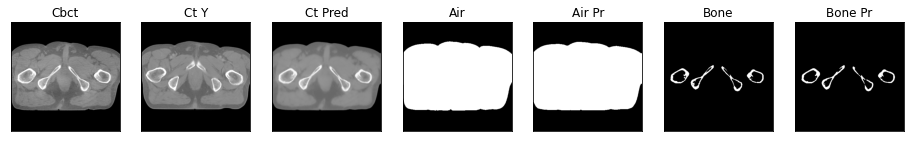

ssim score = 0.7788597345352173
psnr score = 21.39032554626465
snr score = 13.476208686828613
mae error = 0.035030752420425415
air dice score = 0.9962317226829219
bone dice score = 0.925149700599821


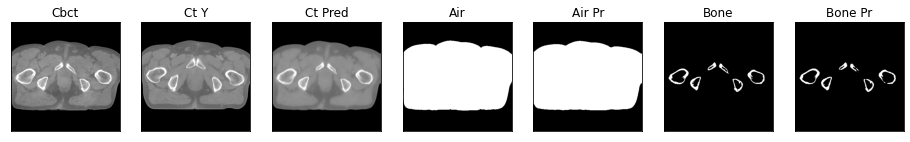

ssim score = 0.7793309688568115
psnr score = 21.5135555267334
snr score = 13.648118019104004
mae error = 0.034763235598802567
air dice score = 0.9966223744238706
bone dice score = 0.934796811708679


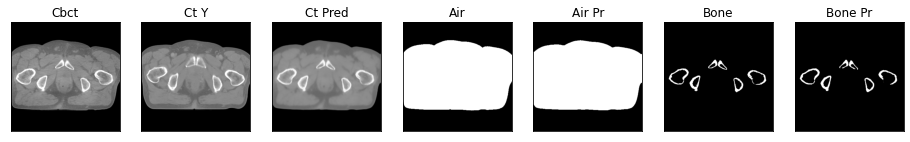

ssim score = 0.771476686000824
psnr score = 21.323463439941406
snr score = 13.480635643005371
mae error = 0.036286838352680206
air dice score = 0.9964020767166334
bone dice score = 0.9329329329337721


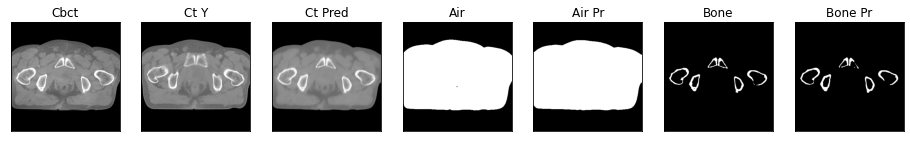

ssim score = 0.7585588097572327
psnr score = 21.239835739135742
snr score = 13.439788818359375
mae error = 0.037879567593336105
air dice score = 0.9965136446720686
bone dice score = 0.9214066556535118


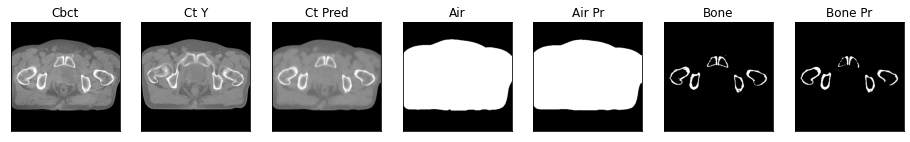

15it [00:33,  2.22s/it]

ssim score = 0.7609108686447144
psnr score = 21.317527770996094
snr score = 13.57581615447998
mae error = 0.03773036599159241
air dice score = 0.9962374484542109
bone dice score = 0.9173894189080942


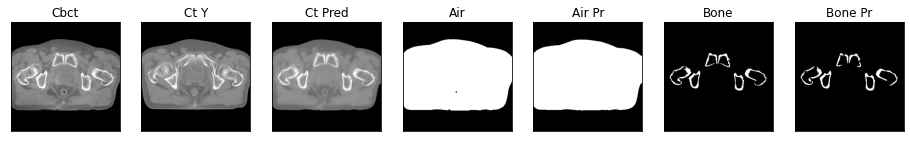

ssim score = 0.7560830116271973
psnr score = 21.064149856567383
snr score = 13.247068405151367
mae error = 0.03998270630836487
air dice score = 0.9959116735387019
bone dice score = 0.9027570419040235


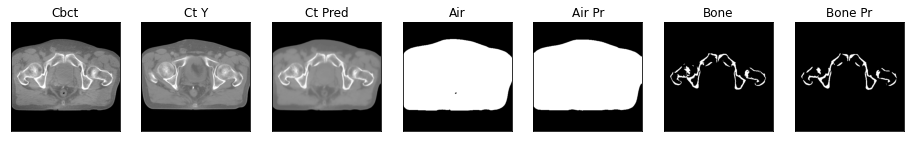

ssim score = 0.7591033577919006
psnr score = 20.962200164794922
snr score = 13.0378999710083
mae error = 0.04074067249894142
air dice score = 0.9960221457150856
bone dice score = 0.8787818864951673


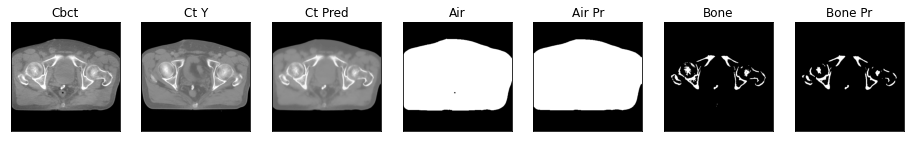

ssim score = 0.7695600986480713
psnr score = 21.16973114013672
snr score = 13.122343063354492
mae error = 0.03998759761452675
air dice score = 0.9959777641957007
bone dice score = 0.8455971049472698


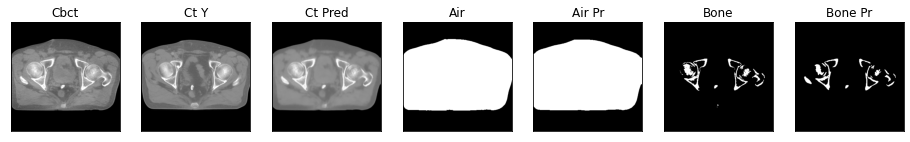

ssim score = 0.7734659314155579
psnr score = 21.363943099975586
snr score = 13.204124450683594
mae error = 0.038804419338703156
air dice score = 0.9961271959498891
bone dice score = 0.8685258964157211


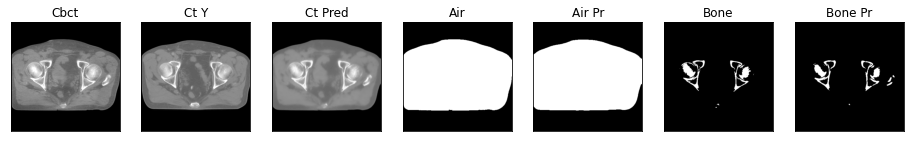

ssim score = 0.7733834385871887
psnr score = 21.699331283569336
snr score = 13.488866806030273
mae error = 0.03600788861513138
air dice score = 0.9959999532158295
bone dice score = 0.8945585432998671


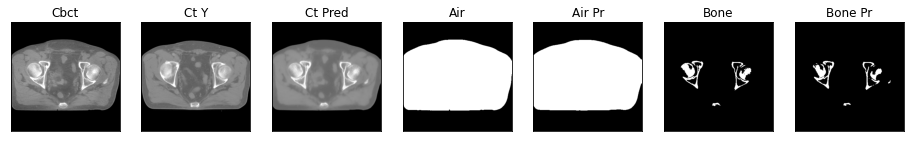

ssim score = 0.7716068625450134
psnr score = 21.550931930541992
snr score = 13.3726224899292
mae error = 0.036885570734739304
air dice score = 0.9959111841140434
bone dice score = 0.9016320143091702


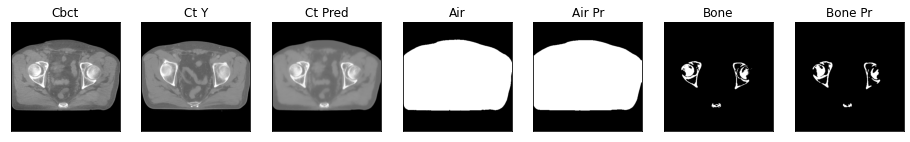

ssim score = 0.771246612071991
psnr score = 21.294612884521484
snr score = 13.129781723022461
mae error = 0.03805890306830406
air dice score = 0.9959880997967563
bone dice score = 0.9061895551268593


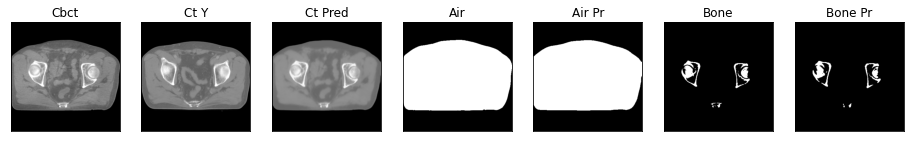

16it [00:36,  2.24s/it]

ssim score = 0.7698651552200317
psnr score = 20.939308166503906
snr score = 12.632981300354004
mae error = 0.039543334394693375
air dice score = 0.9956052547412338
bone dice score = 0.922912966253133


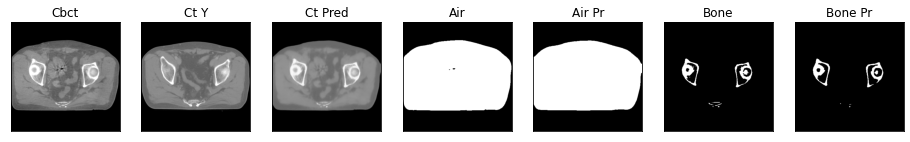

ssim score = 0.7784452438354492
psnr score = 21.065399169921875
snr score = 12.699766159057617
mae error = 0.038644127547740936
air dice score = 0.9964445873756074
bone dice score = 0.9243258117786967


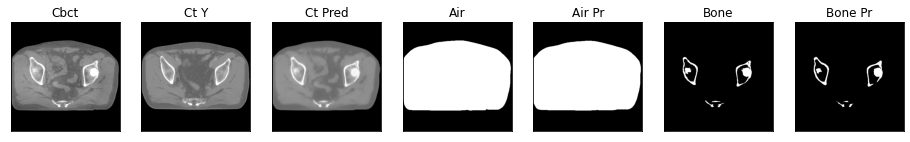

ssim score = 0.7789267301559448
psnr score = 21.40108299255371
snr score = 13.061098098754883
mae error = 0.03637650981545448
air dice score = 0.9964572536534593
bone dice score = 0.9037402696050173


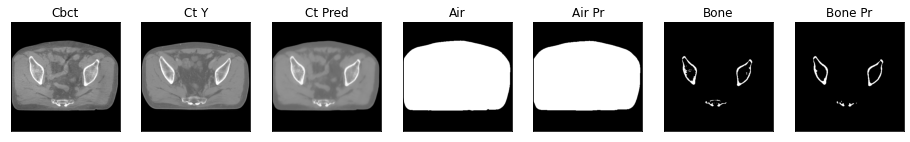

ssim score = 0.7758285403251648
psnr score = 21.38787269592285
snr score = 13.12070083618164
mae error = 0.03636779636144638
air dice score = 0.9959267660206875
bone dice score = 0.916236884226992


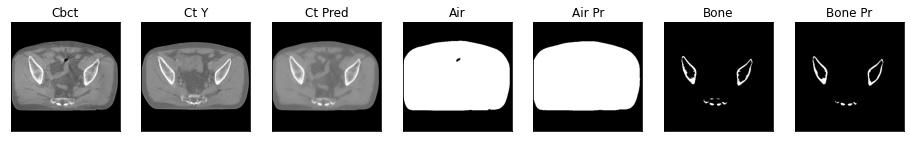

ssim score = 0.7695164680480957
psnr score = 21.131187438964844
snr score = 12.993244171142578
mae error = 0.03807973861694336
air dice score = 0.9953653843826793
bone dice score = 0.9279973757597507


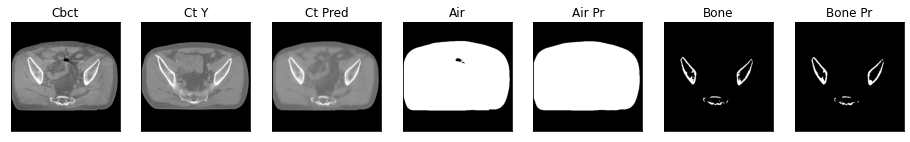

ssim score = 0.7611563801765442
psnr score = 21.013553619384766
snr score = 12.90956974029541
mae error = 0.03866702318191528
air dice score = 0.9949567153555576
bone dice score = 0.9217995169093931


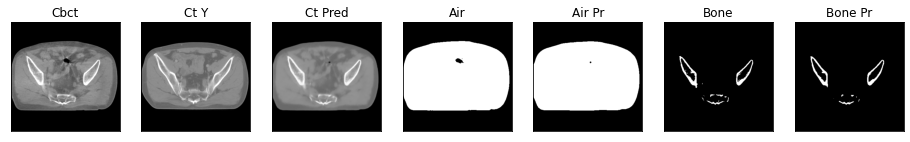

ssim score = 0.7497649192810059
psnr score = 20.88710594177246
snr score = 12.753332138061523
mae error = 0.03954966738820076
air dice score = 0.9960426997581674
bone dice score = 0.9100944437641347


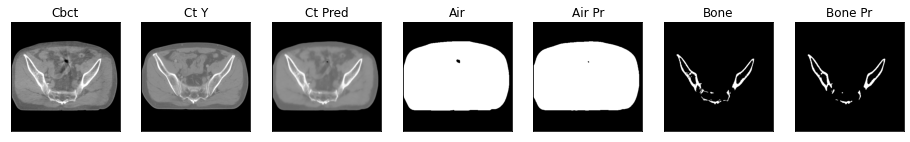

ssim score = 0.7478761672973633
psnr score = 21.053333282470703
snr score = 12.856185913085938
mae error = 0.03856094554066658
air dice score = 0.9967781058202374
bone dice score = 0.9028122956193223


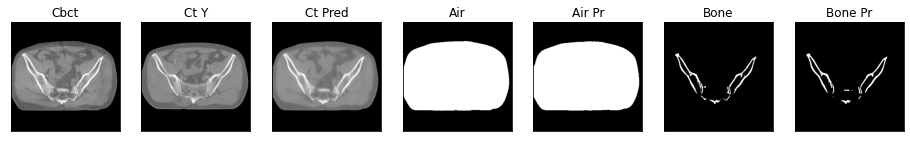

17it [00:38,  2.20s/it]

ssim score = 0.8555164337158203
psnr score = 23.72210693359375
snr score = 15.199499130249023
mae error = 0.025858310982584953
air dice score = 0.9937967785457525
bone dice score = 0.895120444720258


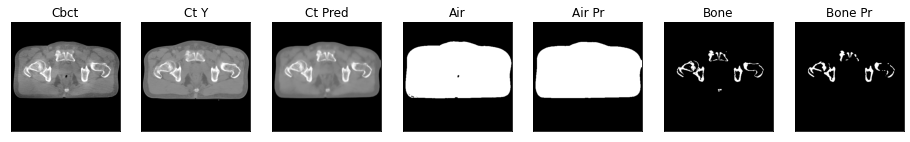

ssim score = 0.8575984239578247
psnr score = 23.92300796508789
snr score = 15.440411567687988
mae error = 0.024997012689709663
air dice score = 0.993350792848145
bone dice score = 0.889032258065948


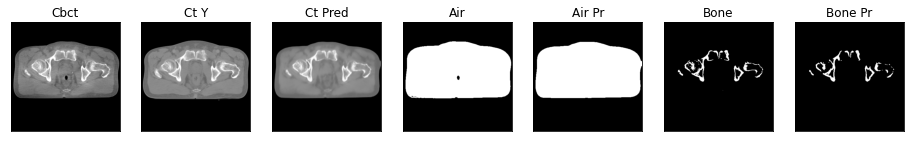

ssim score = 0.8559437990188599
psnr score = 24.01852035522461
snr score = 15.543710708618164
mae error = 0.025295834988355637
air dice score = 0.9936197877294355
bone dice score = 0.8625954198492013


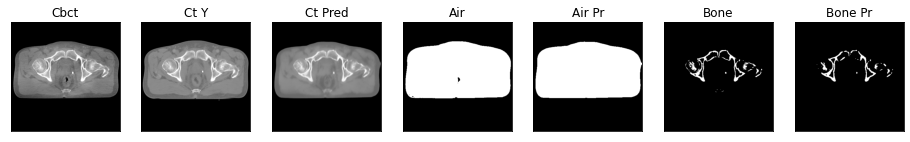

ssim score = 0.8597796559333801
psnr score = 24.19241714477539
snr score = 15.659189224243164
mae error = 0.02417125180363655
air dice score = 0.993123317790672
bone dice score = 0.8674820325322471


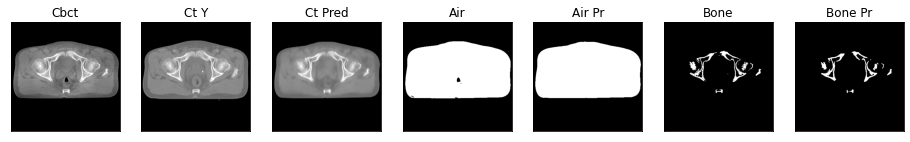

ssim score = 0.8639305233955383
psnr score = 24.341224670410156
snr score = 15.65237045288086
mae error = 0.02251800149679184
air dice score = 0.9931360550939949
bone dice score = 0.8681935386035463


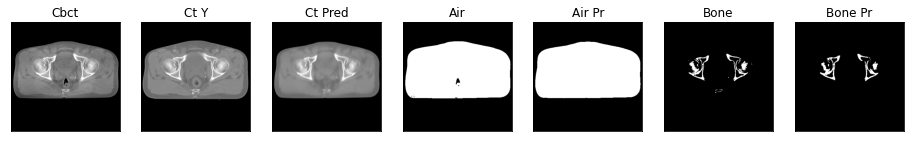

ssim score = 0.8681434988975525
psnr score = 24.47628402709961
snr score = 15.766626358032227
mae error = 0.021970359608530998
air dice score = 0.9936419357789821
bone dice score = 0.8942008486577907


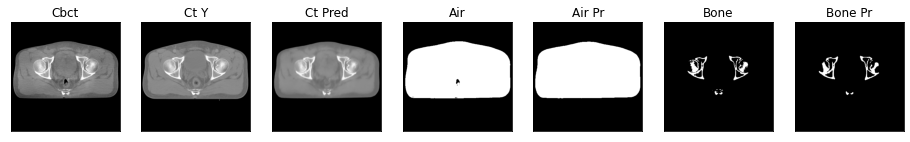

ssim score = 0.8691115975379944
psnr score = 24.52975845336914
snr score = 15.804471015930176
mae error = 0.02187015675008297
air dice score = 0.9934240709588672
bone dice score = 0.8974430239035931


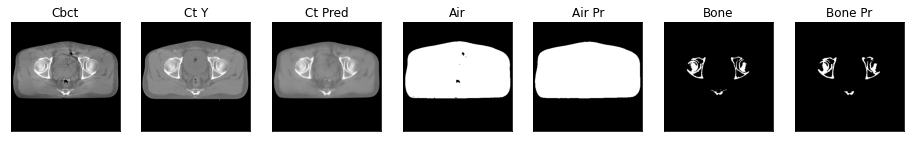

ssim score = 0.8652213215827942
psnr score = 24.03995132446289
snr score = 15.32402515411377
mae error = 0.02292601391673088
air dice score = 0.9927384936596205
bone dice score = 0.9007461635942454


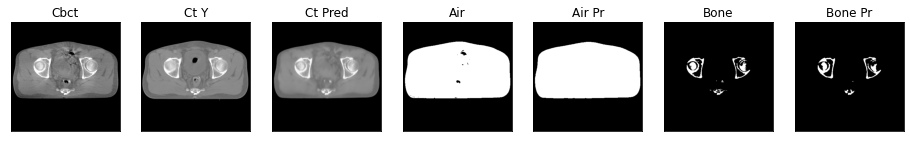

18it [00:40,  2.23s/it]

ssim score = 0.8637741208076477
psnr score = 24.023191452026367
snr score = 15.36305046081543
mae error = 0.023520607501268387
air dice score = 0.9920887416708454
bone dice score = 0.9231190900380551


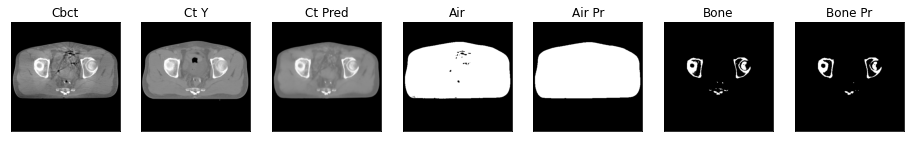

ssim score = 0.8606483936309814
psnr score = 23.464202880859375
snr score = 14.782132148742676
mae error = 0.024346372112631798
air dice score = 0.990141760554669
bone dice score = 0.9222550260098095


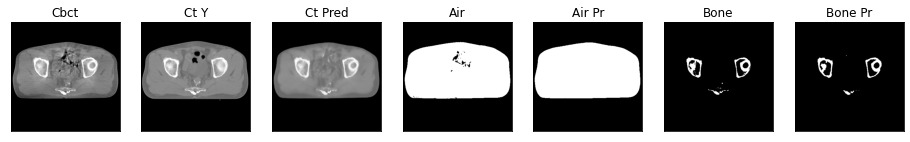

ssim score = 0.861168384552002
psnr score = 23.09391212463379
snr score = 14.34106731414795
mae error = 0.02453552931547165
air dice score = 0.9892035796614463
bone dice score = 0.9044545883849449


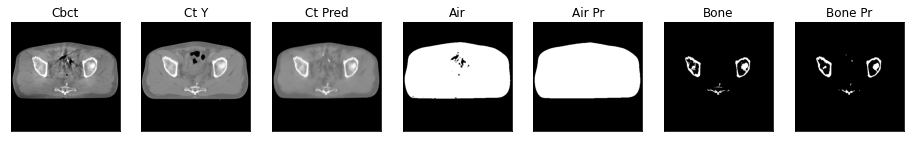

ssim score = 0.8608035445213318
psnr score = 23.336868286132812
snr score = 14.540127754211426
mae error = 0.024259787052869797
air dice score = 0.9910122658877885
bone dice score = 0.9086674430226473


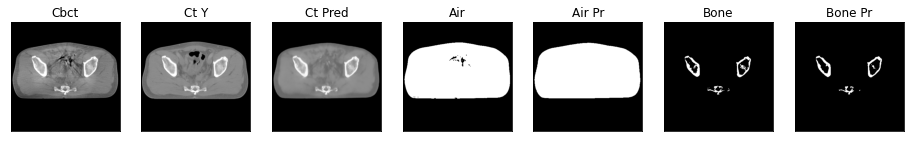

ssim score = 0.8636587858200073
psnr score = 23.70894432067871
snr score = 14.91110897064209
mae error = 0.023401925340294838
air dice score = 0.9907447803053983
bone dice score = 0.9185064935078164


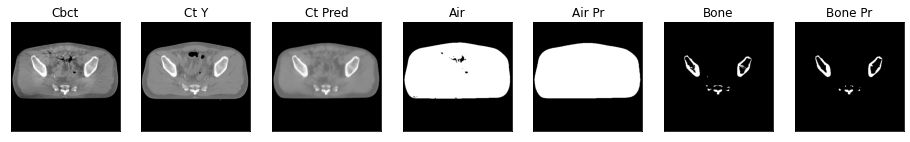

ssim score = 0.8600547909736633
psnr score = 24.036500930786133
snr score = 15.252021789550781
mae error = 0.023129867389798164
air dice score = 0.9885350917036129
bone dice score = 0.9266253869980399


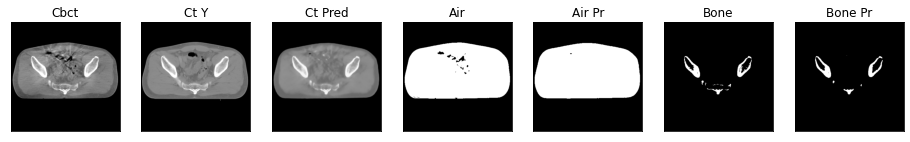

ssim score = 0.8581096529960632
psnr score = 24.30426025390625
snr score = 15.57498836517334
mae error = 0.02280413545668125
air dice score = 0.9876263876122561
bone dice score = 0.9304359007338249


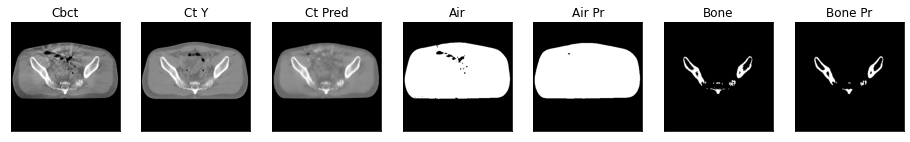

ssim score = 0.8588842749595642
psnr score = 23.809574127197266
snr score = 15.0996675491333
mae error = 0.023509787395596504
air dice score = 0.9883935180081668
bone dice score = 0.9235810722254085


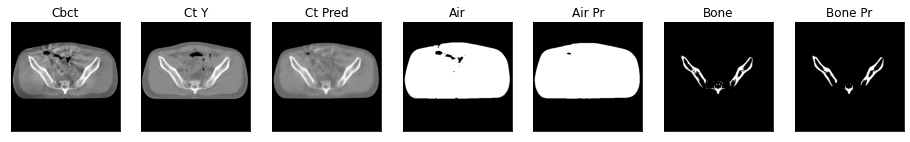

19it [00:42,  2.19s/it]

ssim score = 0.8626236915588379
psnr score = 23.535980224609375
snr score = 14.77133846282959
mae error = 0.023570476099848747
air dice score = 0.9899226881229511
bone dice score = 0.9113561506528518


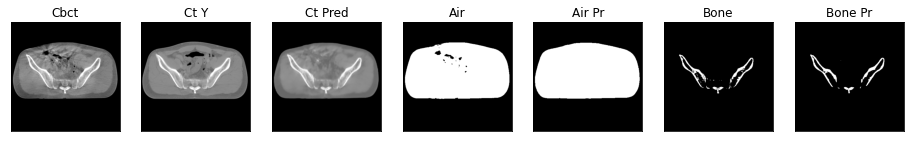

ssim score = 0.862383246421814
psnr score = 23.468643188476562
snr score = 14.667648315429688
mae error = 0.023815017193555832
air dice score = 0.9922547738614421
bone dice score = 0.890857142858702


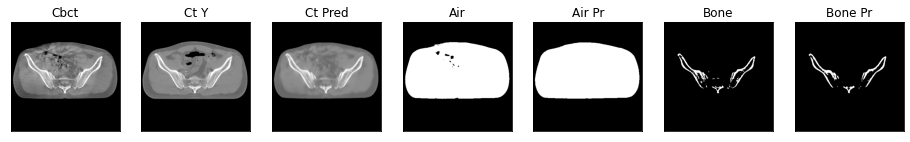

ssim score = 0.8665089011192322
psnr score = 23.531082153320312
snr score = 14.730155944824219
mae error = 0.023331603035330772
air dice score = 0.9921152030217248
bone dice score = 0.8963657377694059


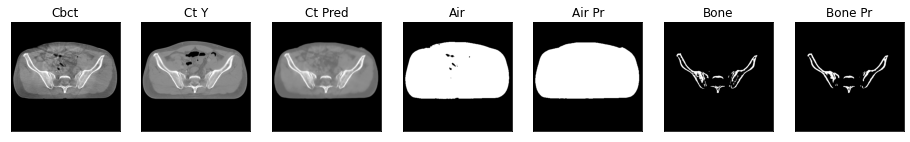

ssim score = 0.8678444027900696
psnr score = 24.00627899169922
snr score = 15.203933715820312
mae error = 0.022720864042639732
air dice score = 0.9913298442524817
bone dice score = 0.8895857833543762


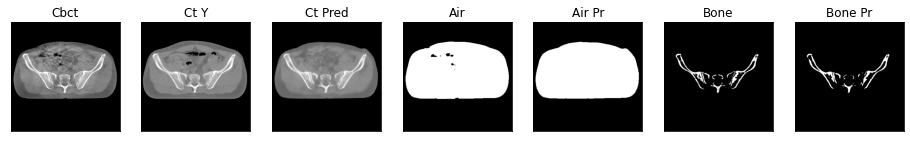

ssim score = 0.8611994385719299
psnr score = 23.67630386352539
snr score = 14.878996849060059
mae error = 0.023722337558865547
air dice score = 0.9898010127665725
bone dice score = 0.880841432567157


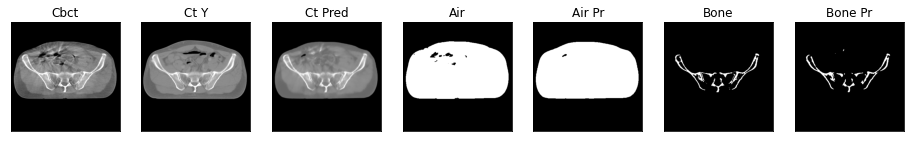

ssim score = 0.8598166108131409
psnr score = 23.569786071777344
snr score = 14.755207061767578
mae error = 0.0238942950963974
air dice score = 0.9866802382448239
bone dice score = 0.8839297504306889


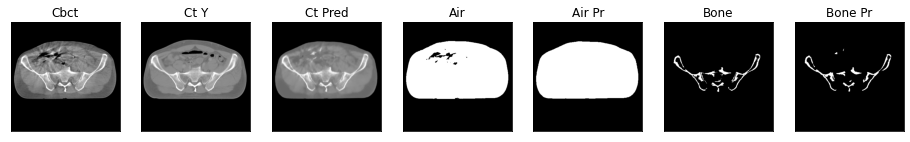

ssim score = 0.8549514412879944
psnr score = 23.00736427307129
snr score = 14.174160957336426
mae error = 0.02557840570807457
air dice score = 0.986301588441328
bone dice score = 0.8745401496907962


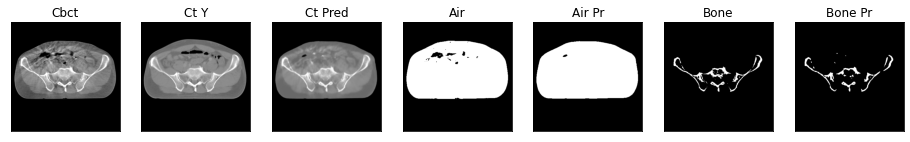

ssim score = 0.8431611657142639
psnr score = 22.26297378540039
snr score = 13.383831977844238
mae error = 0.02771167643368244
air dice score = 0.9872268772802091
bone dice score = 0.8581055784368139


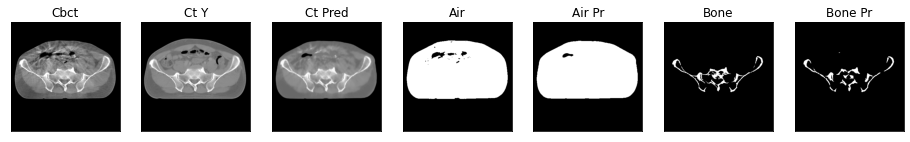

20it [00:44,  2.22s/it]

ssim score = 0.8396639823913574
psnr score = 22.488439559936523
snr score = 13.555500030517578
mae error = 0.02738952450454235
air dice score = 0.9852631240246591
bone dice score = 0.8906061337854309


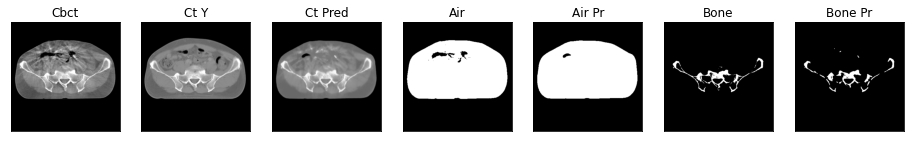

ssim score = 0.8341439366340637
psnr score = 22.409887313842773
snr score = 13.507410049438477
mae error = 0.028304921463131905
air dice score = 0.9827849976649574
bone dice score = 0.8963234424885171


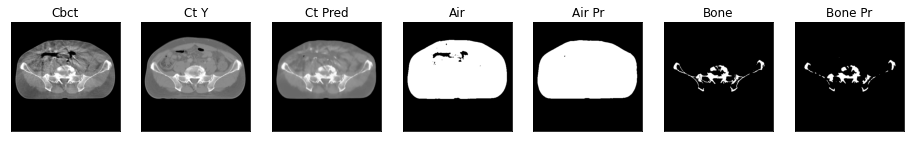

ssim score = 0.8290724754333496
psnr score = 21.925413131713867
snr score = 12.967710494995117
mae error = 0.029039854183793068
air dice score = 0.9832533763354298
bone dice score = 0.8820461882309157


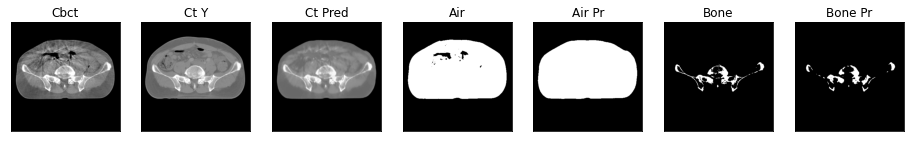

ssim score = 0.8402284979820251
psnr score = 22.69708251953125
snr score = 13.591846466064453
mae error = 0.026583680883049965
air dice score = 0.9875028255885399
bone dice score = 0.9008498583582172


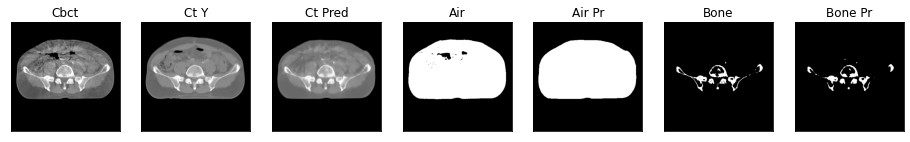

ssim score = 0.8852576613426208
psnr score = 26.80243492126465
snr score = 17.183347702026367
mae error = 0.016251815482974052
air dice score = 0.9960418009805568
bone dice score = 0.951889100300302


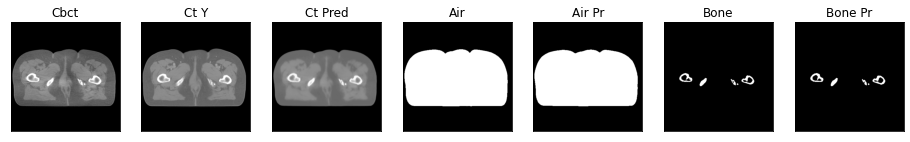

ssim score = 0.8846337795257568
psnr score = 26.906652450561523
snr score = 17.40857696533203
mae error = 0.016380110755562782
air dice score = 0.9961484880767053
bone dice score = 0.9478976234015563


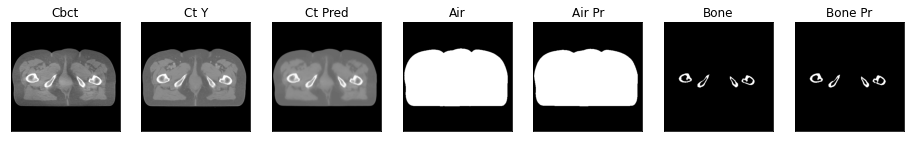

ssim score = 0.8803892731666565
psnr score = 26.7868595123291
snr score = 17.37169647216797
mae error = 0.01688113994896412
air dice score = 0.995941762815294
bone dice score = 0.9355847404641321


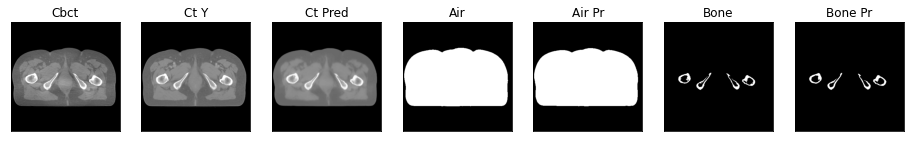

ssim score = 0.8770154714584351
psnr score = 26.71126937866211
snr score = 17.359554290771484
mae error = 0.017183933407068253
air dice score = 0.9958142962417127
bone dice score = 0.9376744186058107


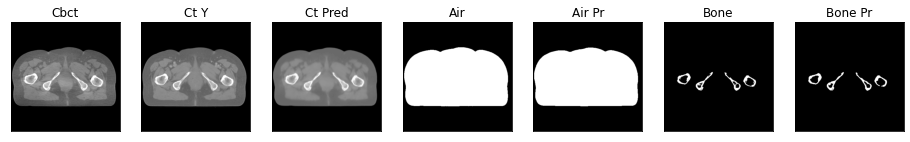

21it [00:46,  2.18s/it]

ssim score = 0.8763089179992676
psnr score = 26.472213745117188
snr score = 17.148962020874023
mae error = 0.017663462087512016
air dice score = 0.9959892458900819
bone dice score = 0.9387176762320454


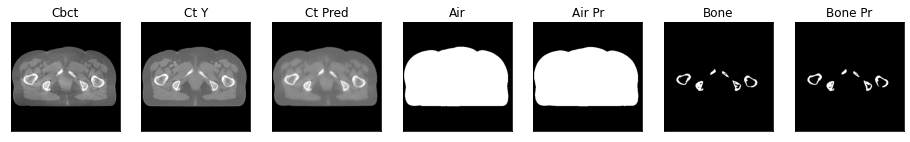

ssim score = 0.8772162199020386
psnr score = 26.378459930419922
snr score = 17.078163146972656
mae error = 0.01758883334696293
air dice score = 0.9959630446409631
bone dice score = 0.93132019885967


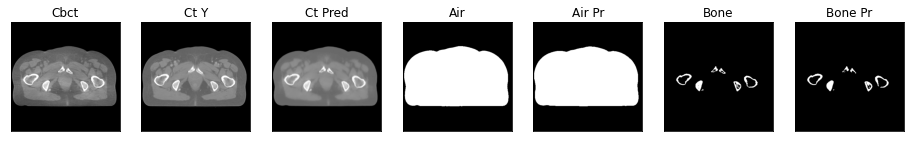

ssim score = 0.8741480112075806
psnr score = 26.25033950805664
snr score = 16.981369018554688
mae error = 0.017863819375634193
air dice score = 0.9960020172636871
bone dice score = 0.9276626681219982


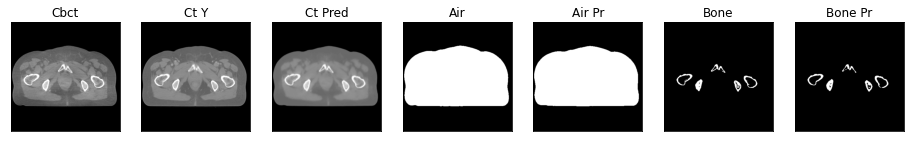

ssim score = 0.8740075826644897
psnr score = 26.202516555786133
snr score = 16.981910705566406
mae error = 0.01824963092803955
air dice score = 0.9950917377585639
bone dice score = 0.9271922054928753


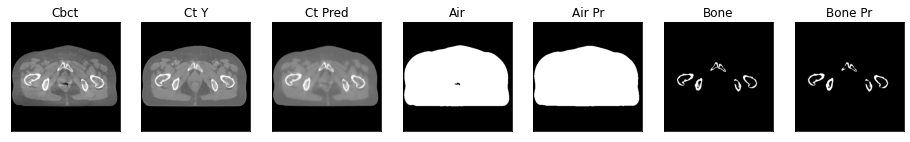

ssim score = 0.8756738901138306
psnr score = 26.21307373046875
snr score = 17.03521156311035
mae error = 0.01802702806890011
air dice score = 0.9946052487498671
bone dice score = 0.9213260762011987


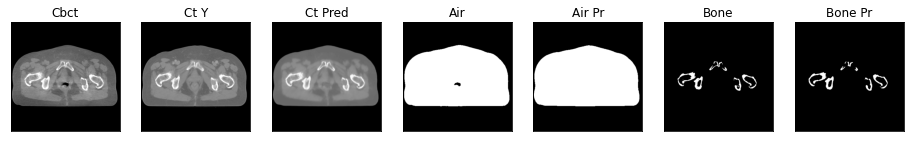

ssim score = 0.8751212954521179
psnr score = 26.412391662597656
snr score = 17.32223129272461
mae error = 0.017883727326989174
air dice score = 0.9936537114845985
bone dice score = 0.916129032259267


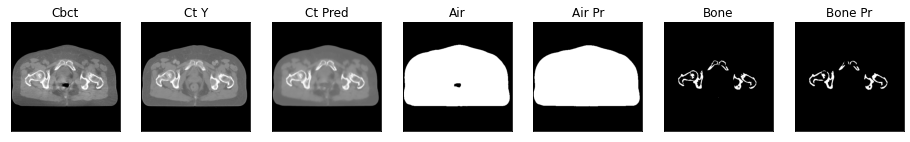

ssim score = 0.8755887150764465
psnr score = 26.731159210205078
snr score = 17.754274368286133
mae error = 0.0178206954151392
air dice score = 0.9952529460086252
bone dice score = 0.9160414433736328


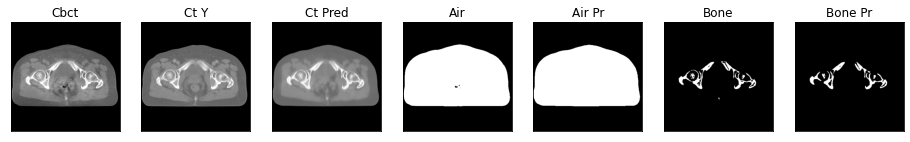

ssim score = 0.8792890310287476
psnr score = 26.98285675048828
snr score = 17.877418518066406
mae error = 0.017311247065663338
air dice score = 0.9925989472765925
bone dice score = 0.8922970877151077


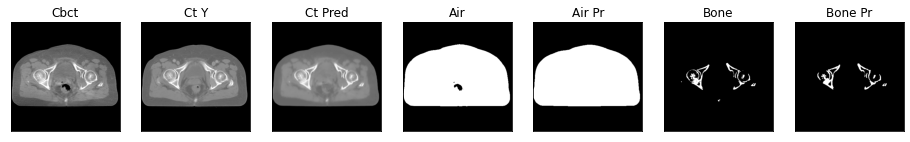

22it [00:49,  2.21s/it]

ssim score = 0.8806189894676208
psnr score = 27.31551170349121
snr score = 18.100650787353516
mae error = 0.017057964578270912
air dice score = 0.9926769967703359
bone dice score = 0.8776387802994988


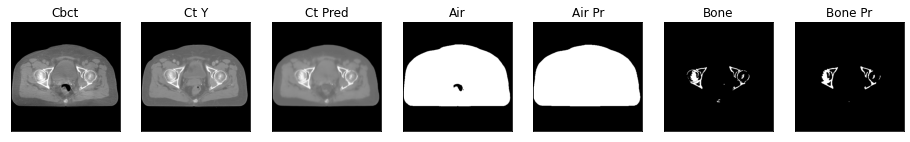

ssim score = 0.8835563659667969
psnr score = 27.22347640991211
snr score = 17.981489181518555
mae error = 0.01759362407028675
air dice score = 0.992807317143772
bone dice score = 0.8956264157536918


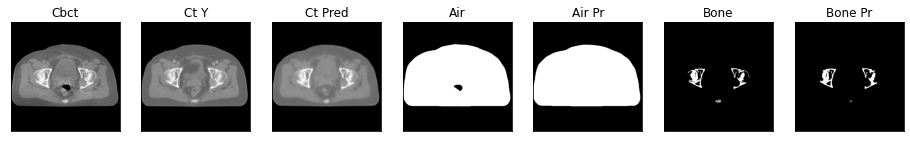

ssim score = 0.8836708068847656
psnr score = 26.913150787353516
snr score = 17.663158416748047
mae error = 0.01836727373301983
air dice score = 0.994611449591911
bone dice score = 0.9119360745811231


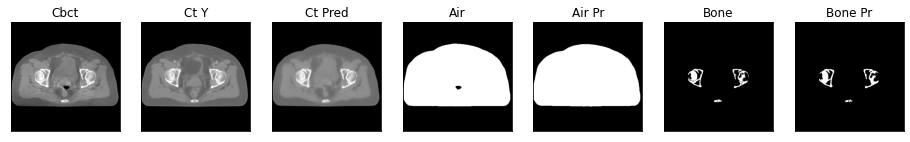

ssim score = 0.8823257684707642
psnr score = 27.133544921875
snr score = 17.917781829833984
mae error = 0.01757090725004673
air dice score = 0.9960090651235081
bone dice score = 0.9338595106561348


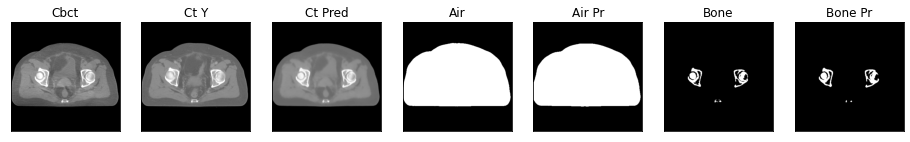

ssim score = 0.8779373168945312
psnr score = 26.661285400390625
snr score = 17.49701690673828
mae error = 0.018038310110569
air dice score = 0.9962245475113148
bone dice score = 0.9494028912641514


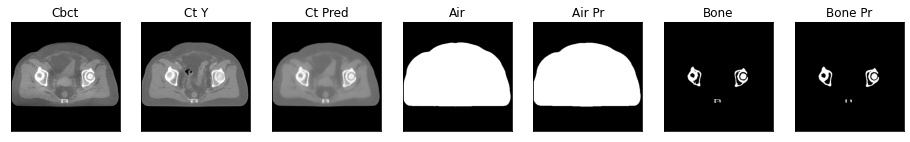

ssim score = 0.8671702146530151
psnr score = 25.639436721801758
snr score = 16.51272201538086
mae error = 0.01962725631892681
air dice score = 0.996165843058917
bone dice score = 0.9453919035323791


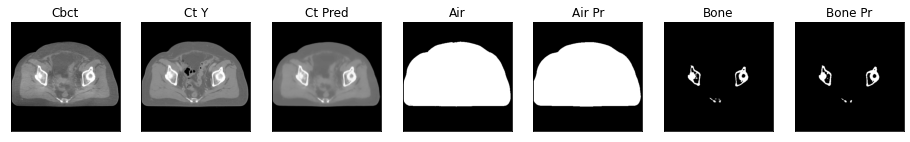

ssim score = 0.8546879291534424
psnr score = 24.26873779296875
snr score = 15.069585800170898
mae error = 0.02187510021030903
air dice score = 0.9942494326014047
bone dice score = 0.9331562638350341


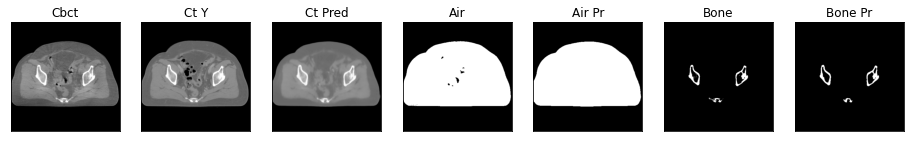

ssim score = 0.8508650660514832
psnr score = 24.22056007385254
snr score = 15.003416061401367
mae error = 0.022600829601287842
air dice score = 0.9918031653880767
bone dice score = 0.9333033909738759


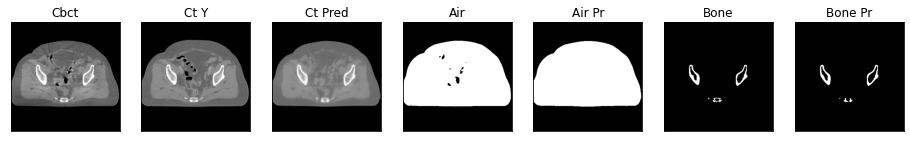

23it [00:51,  2.24s/it]

ssim score = 0.849493682384491
psnr score = 24.56651496887207
snr score = 15.414284706115723
mae error = 0.02242794819176197
air dice score = 0.9920536600390185
bone dice score = 0.9323439546064526


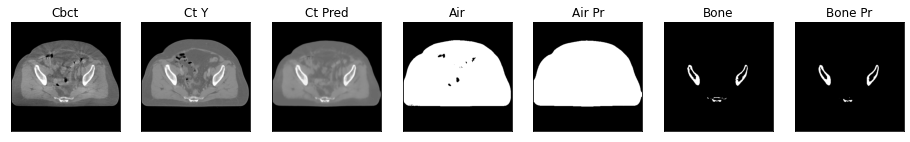

ssim score = 0.848909318447113
psnr score = 24.41089630126953
snr score = 15.313760757446289
mae error = 0.02282223477959633
air dice score = 0.9925197865899238
bone dice score = 0.9408053442208052


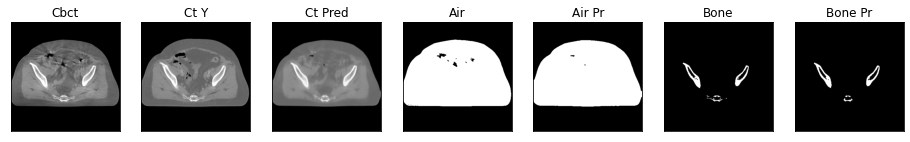

ssim score = 0.8459874391555786
psnr score = 24.043825149536133
snr score = 15.01111888885498
mae error = 0.023738939315080643
air dice score = 0.9928405767873397
bone dice score = 0.9392248062024926


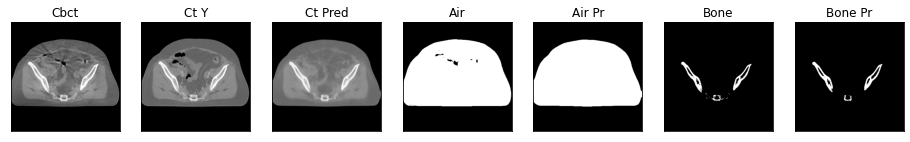

ssim score = 0.8470590710639954
psnr score = 24.129676818847656
snr score = 15.169830322265625
mae error = 0.023910600692033768
air dice score = 0.9922916888936357
bone dice score = 0.9218118869024551


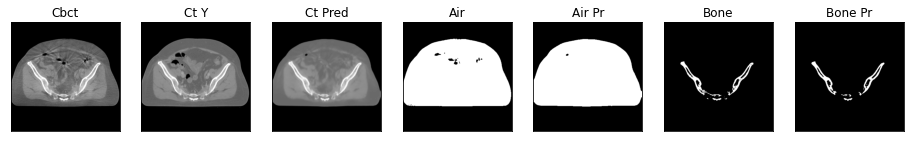

ssim score = 0.845242977142334
psnr score = 24.220985412597656
snr score = 15.256852149963379
mae error = 0.02386794239282608
air dice score = 0.9922409858512147
bone dice score = 0.9070137382515254


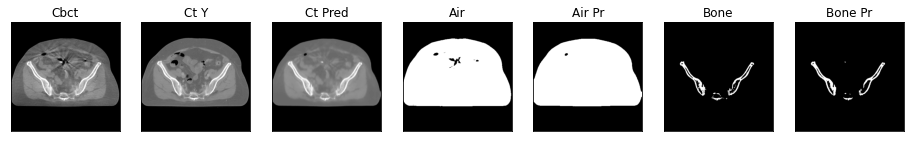

ssim score = 0.842839241027832
psnr score = 24.029380798339844
snr score = 15.043068885803223
mae error = 0.02417571097612381
air dice score = 0.9929411456559936
bone dice score = 0.9035222052080812


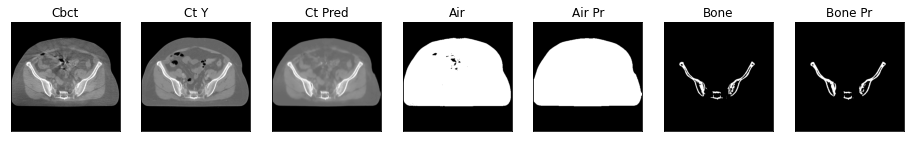

ssim score = 0.8477903008460999
psnr score = 24.546422958374023
snr score = 15.571744918823242
mae error = 0.02322092279791832
air dice score = 0.994767660767846
bone dice score = 0.9101355332953722


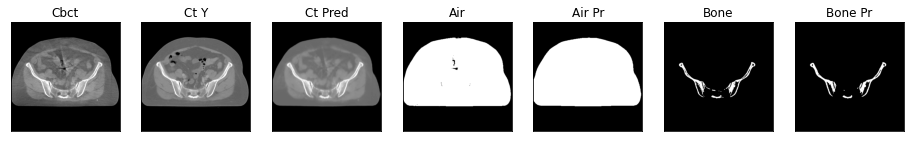

24it [00:53,  2.23s/it]


In [34]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [35]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [36]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [37]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
eval_epoch(model, discriminator, testloader, device)

24it [00:07,  3.38it/s]


(0.8560696095228195,
 24.32110357284546,
 15.335673650105795,
 0.023914100253023207,
 0.9913540214503759,
 0.919028454974292,
 0.3333333333333333)

In [ ]:
# import torchvision.models as models
# models.vgg16(pretrained=True)